In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 30
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "ga-50"
number_of_opt_evaluations = 100
run_i = 1


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


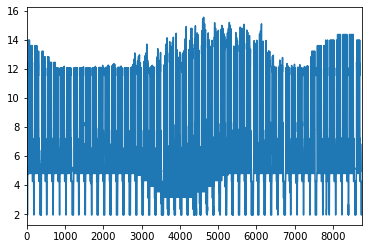

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.7256627082824707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.736743688583374 sec


ERROR:root:Finished Generation of Irradiance


0.0


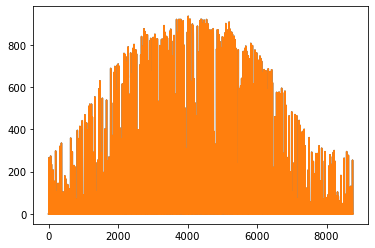

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4932444095611572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.499160051345825 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4689061641693115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   8 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


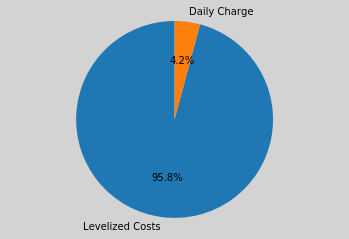

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (164.3770342289737, 163.93296404340862, 153.51219518867362, 47.84420512805346, 46.341538598003396, 19.201794965184856, 0.8397240917575481, 0.34410273757780496, 0.5896076530687592)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 47.8
                                           and a gcr of 0.840


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.500887870788574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 46.3
                                           and a gcr of 0.344


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.44688081741333 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 19.2
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.48006534576416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   8 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 67.602, 237.201]


ERROR:ga_logger:Cost: 3160.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,160 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[164.3770342289737, 163.93296404340862, 153.51219518867362, 47.84420512805346, 46.341538598003396, 19.201794965184856, 0.8397240917575481, 0.34410273757780496, 0.5896076530687592, 3160.42, 304.803, 0.0, 67.602, 237.201, {'Levelized Costs': 3027.3579999999997, 'Energy Charge': 0.02000000000032287, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60099977006, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (156.09944679229517, 195.33121906368515, 153.778570624422, 45.88099590218339, 29.729929568684707, 50.74856909450723, 0.827797820274164, 0.28194755593443865, 0.6718956394028637)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 45.9
                                           and a gcr of 0.828


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.489933490753174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 29.7
                                           and a gcr of 0.282


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4091222286224365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 50.7
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5114009380340576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [240.161, 87.0207, 0.0]


ERROR:ga_logger:Cost: 3382.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,383 per year


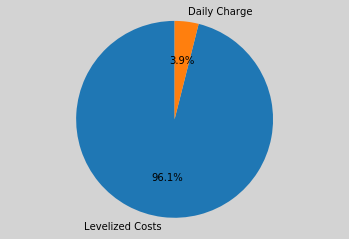

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[156.09944679229517, 195.33121906368515, 153.778570624422, 45.88099590218339, 29.729929568684707, 50.74856909450723, 0.827797820274164, 0.28194755593443865, 0.6718956394028637, 3382.69, 327.1817, 240.161, 87.0207, 0.0, {'Levelized Costs': 3249.63, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60149628344, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.14447024371272, 124.49630965147716, 134.21716165640535, 25.204940326709362, 55.4648226799721, 1.142720700341702, 0.7311874206569526, 0.8541188155138169, 0.4223673534518776)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 114
                                           a tilt of 25.2
                                           and a gcr of 0.731


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4058380126953125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 124
                                           a tilt of 55.5
                                           and a gcr of 0.854


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.394181966781616 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 134
                                           a tilt of 1.1
                                           and a gcr of 0.422


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.6927661895751953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   7 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [208.568, 0.0, 132.419]


ERROR:ga_logger:Cost: 3519.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,520 per year


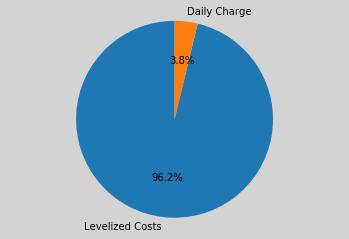

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[114.14447024371272, 124.49630965147716, 134.21716165640535, 25.204940326709362, 55.4648226799721, 1.142720700341702, 0.7311874206569526, 0.8541188155138169, 0.4223673534518776, 3519.81, 340.987, 208.568, 0.0, 132.419, {'Levelized Costs': 3386.754, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60000677003, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (157.8388324050911, 126.46880003244812, 175.97159250721631, 16.777030159651652, 55.264474724349995, 43.800789058773155, 0.39889953248617094, 0.6500974995592121, 0.2537447896264078)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 16.8
                                           and a gcr of 0.399


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4312667846679688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 126
                                           a tilt of 55.3
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.431563377380371 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 43.8
                                           and a gcr of 0.254


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.445455312728882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [24.1425, 349.908, 0.0]


ERROR:ga_logger:Cost: 3848.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,848 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[157.8388324050911, 126.46880003244812, 175.97159250721631, 16.777030159651652, 55.264474724349995, 43.800789058773155, 0.39889953248617094, 0.6500974995592121, 0.2537447896264078, 3848.2, 374.0505, 24.1425, 349.908, 0.0, {'Levelized Costs': 3715.145, 'Energy Charge': 0.012999999999806278, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60071129, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (213.53547188193363, 118.9036859569486, 138.05332881567932, 22.554318679794495, 45.0715493342465, 2.0560860336393594, 0.6068957859260165, 0.22450480633504527, 0.22945942344819756)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 22.6
                                           and a gcr of 0.607


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5356147289276123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 119
                                           a tilt of 45.1
                                           and a gcr of 0.225


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4356796741485596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 2.1
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.331124782562256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [310.267, 0.0, 0.0]


ERROR:ga_logger:Cost: 3214.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,215 per year


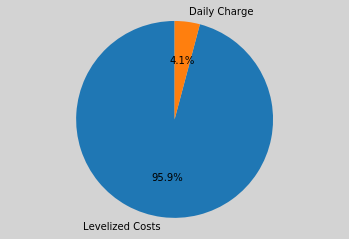

Total roof area of the  building: 599 m2
Total roof area used 511 m2
Percentage: 85.4%
succes
[[213.53547188193363, 118.9036859569486, 138.05332881567932, 22.554318679794495, 45.0715493342465, 2.0560860336393594, 0.6068957859260165, 0.22450480633504527, 0.22945942344819756, 3214.69, 310.267, 310.267, 0.0, 0.0, {'Levelized Costs': 3081.615, 'Energy Charge': 0.03300000000018599, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60075268203, 61845.7, 511.236]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200.82875970837395, 244.1738771242925, 209.09424982903704, 3.0518226373968247, 43.76370460427724, 55.75887203550969, 0.3181346480904355, 0.6545376489715159, 0.27073197189937953)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 3.1
                                           and a gcr of 0.318


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2721753120422363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 244
                                           a tilt of 43.8
                                           and a gcr of 0.655


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.399785280227661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 209
                                           a tilt of 55.8
                                           and a gcr of 0.271


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7790944576263428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [18.7707, 353.293, 0.0]


ERROR:ga_logger:Cost: 3828.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,828 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[200.82875970837395, 244.1738771242925, 209.09424982903704, 3.0518226373968247, 43.76370460427724, 55.75887203550969, 0.3181346480904355, 0.6545376489715159, 0.27073197189937953, 3828.47, 372.0637, 18.7707, 353.293, 0.0, {'Levelized Costs': 3695.424, 'Energy Charge': 0.004000000000075943, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60075895908, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.0728187700838, 146.29984733492893, 248.28968290947367, 36.94267190488786, 1.4378322465945528, 38.56591160094475, 0.6199559009039567, 0.6053085015180887, 0.6247548465405709)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 36.9
                                           and a gcr of 0.620


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4423112869262695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 146
                                           a tilt of 1.4
                                           and a gcr of 0.605


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.278782844543457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 38.6
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4367260932922363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   8 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 121 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [307.633, 0.0, 0.0]


ERROR:ga_logger:Cost: 3188.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,189 per year


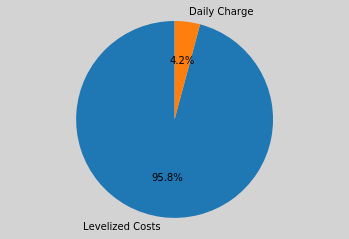

Total roof area of the  building: 599 m2
Total roof area used 496 m2
Percentage: 82.9%
succes
[[162.0728187700838, 146.29984733492893, 248.28968290947367, 36.94267190488786, 1.4378322465945528, 38.56591160094475, 0.6199559009039567, 0.6053085015180887, 0.6247548465405709, 3188.52, 307.633, 307.633, 0.0, 0.0, {'Levelized Costs': 3055.466, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600815100115, 61845.7, 496.217]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (142.740582783427, 97.4819859219852, 165.029150854418, 37.944003629632924, 36.716361641068566, 17.487888526728344, 0.828374831056097, 0.4386780196686785, 0.5897572125733093)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 37.9
                                           and a gcr of 0.828


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.433121681213379 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 36.7
                                           and a gcr of 0.439


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3704755306243896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 17.5
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4188756942749023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 304.368]


ERROR:ga_logger:Cost: 3156.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,156 per year


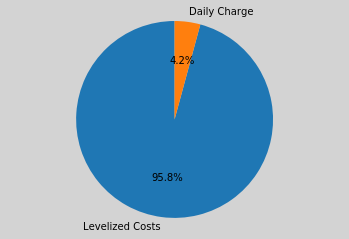

Total roof area of the  building: 599 m2
Total roof area used 516 m2
Percentage: 86.2%
succes
[[142.740582783427, 97.4819859219852, 165.029150854418, 37.944003629632924, 36.716361641068566, 17.487888526728344, 0.828374831056097, 0.4386780196686785, 0.5897572125733093, 3156.1, 304.368, 0.0, 0.0, 304.368, {'Levelized Costs': 3023.038, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60120409985, 61845.7, 516.09]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (187.37571369485977, 95.13184816861614, 209.71577333137623, 20.450156682823422, 24.790782395826003, 23.62220844805753, 0.8524846382844793, 0.3696313736362835, 0.8145483010055334)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 187
                                           a tilt of 20.5
                                           and a gcr of 0.852


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4728152751922607 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 24.8
                                           and a gcr of 0.370


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4507718086242676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 23.6
                                           and a gcr of 0.815


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.460489511489868 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [314.588, 0.0, 0.0]


ERROR:ga_logger:Cost: 3257.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,258 per year


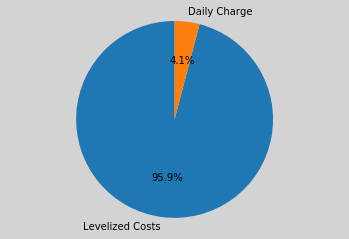

Total roof area of the  building: 599 m2
Total roof area used 369 m2
Percentage: 61.6%
succes
[[187.37571369485977, 95.13184816861614, 209.71577333137623, 20.450156682823422, 24.790782395826003, 23.62220844805753, 0.8524846382844793, 0.3696313736362835, 0.8145483010055334, 3257.6, 314.588, 314.588, 0.0, 0.0, {'Levelized Costs': 3124.537, 'Energy Charge': 0.021000000000128694, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602978602656, 61845.7, 369.024]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (192.15890642400484, 235.9438301731134, 263.06892307574645, 18.235027993812245, 17.34301787314801, 36.48484750625577, 0.7706586349789728, 0.4638585022496177, 0.40560811086246895)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 18.2
                                           and a gcr of 0.771


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7147536277770996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 236
                                           a tilt of 17.3
                                           and a gcr of 0.464


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8011574745178223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 36.5
                                           and a gcr of 0.406


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.523094892501831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [310.306, 0.0, 0.0]


ERROR:ga_logger:Cost: 3215.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,215 per year


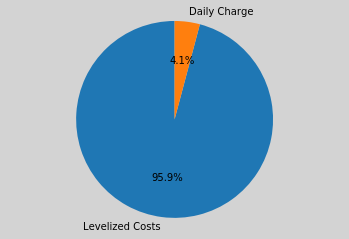

Total roof area of the  building: 599 m2
Total roof area used 403 m2
Percentage: 67.2%
succes
[[192.15890642400484, 235.9438301731134, 263.06892307574645, 18.235027993812245, 17.34301787314801, 36.48484750625577, 0.7706586349789728, 0.4638585022496177, 0.40560811086246895, 3215.08, 310.306, 310.306, 0.0, 0.0, {'Levelized Costs': 3082.0209999999997, 'Energy Charge': 0.01700000000039381, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59965309185, 61845.7, 402.651]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105.67952003043311, 215.87706011788708, 246.8004563963089, 2.102696368278287, 43.55927512309246, 54.75461693060886, 0.8738020990791195, 0.49124542505548097, 0.49613042810029157)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 2.1
                                           and a gcr of 0.874


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3559062480926514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 43.6
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.441929340362549 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 247
                                           a tilt of 54.8
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.416727066040039 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [62.6363, 258.925, 0.0]


ERROR:ga_logger:Cost: 3326.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,327 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[105.67952003043311, 215.87706011788708, 246.8004563963089, 2.102696368278287, 43.55927512309246, 54.75461693060886, 0.8738020990791195, 0.49124542505548097, 0.49613042810029157, 3326.87, 321.5613, 62.6363, 258.925, 0.0, {'Levelized Costs': 3193.8129999999996, 'Energy Charge': 0.015000000000156888, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6018885395, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.7084553017349, 162.23995541167153, 189.57352808075865, 34.068802833023064, 13.113250455608224, 45.59829305778563, 0.23304800970789236, 0.7294892867841896, 0.723156993612911)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 34.1
                                           and a gcr of 0.233


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4097602367401123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 162
                                           a tilt of 13.1
                                           and a gcr of 0.729


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3915257453918457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 45.6
                                           and a gcr of 0.723


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.470261812210083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [60.5657, 247.207, 0.0]


ERROR:ga_logger:Cost: 3189.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,190 per year


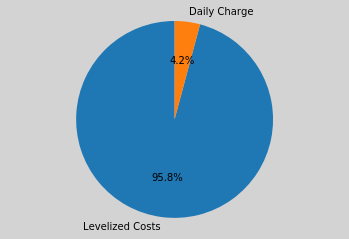

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[169.7084553017349, 162.23995541167153, 189.57352808075865, 34.068802833023064, 13.113250455608224, 45.59829305778563, 0.23304800970789236, 0.7294892867841896, 0.723156993612911, 3189.91, 307.7727, 60.5657, 247.207, 0.0, {'Levelized Costs': 3056.8529999999996, 'Energy Charge': 0.015000000000327418, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6011581758, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.75710856814791, 235.37239569540245, 164.5185083823479, 13.169969969342354, 37.367080228572775, 20.478093380177235, 0.8766791502094702, 0.8330489441641717, 0.8105823082853052)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 13.2
                                           and a gcr of 0.877


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4023313522338867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 37.4
                                           and a gcr of 0.833


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4151511192321777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 20.5
                                           and a gcr of 0.811


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4057607650756836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   8 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.193]


ERROR:ga_logger:Cost: 3253.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,254 per year


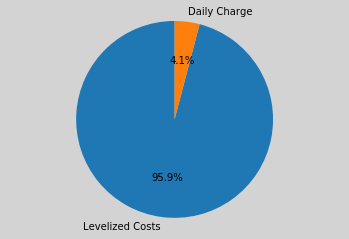

Total roof area of the  building: 599 m2
Total roof area used 388 m2
Percentage: 64.7%
succes
[[124.75710856814791, 235.37239569540245, 164.5185083823479, 13.169969969342354, 37.367080228572775, 20.478093380177235, 0.8766791502094702, 0.8330489441641717, 0.8105823082853052, 3253.69, 314.193, 0.0, 0.0, 314.193, {'Levelized Costs': 3120.632, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601693069, 61845.7, 387.614]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.60744267889764, 175.1849950853951, 151.17833349962405, 37.83084093913595, 45.462591381730626, 41.89115316282817, 0.5983636823595935, 0.7776646650563468, 0.39553328369900403)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 37.8
                                           and a gcr of 0.598


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3824877738952637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 45.5
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3831706047058105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 41.9
                                           and a gcr of 0.396


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.390786647796631 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   8 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 155.683, 157.647]


ERROR:ga_logger:Cost: 3245.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,245 per year


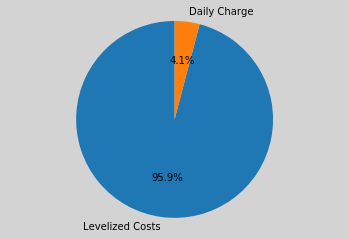

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.60744267889764, 175.1849950853951, 151.17833349962405, 37.83084093913595, 45.462591381730626, 41.89115316282817, 0.5983636823595935, 0.7776646650563468, 0.39553328369900403, 3245.11, 313.33, 0.0, 155.683, 157.647, {'Levelized Costs': 3112.054, 'Energy Charge': 0.013999999999953161, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604008752016, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (198.1529427920512, 162.76090123190977, 233.40647290824538, 38.441804962294654, 34.40560169825403, 41.387751384037486, 0.39402881758925223, 0.8372784613584869, 0.7811628630547165)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 38.4
                                           and a gcr of 0.394


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5080599784851074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 34.4
                                           and a gcr of 0.837


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.398179292678833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 41.4
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4782040119171143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [171.063, 137.835, 0.0]


ERROR:ga_logger:Cost: 3201.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,201 per year


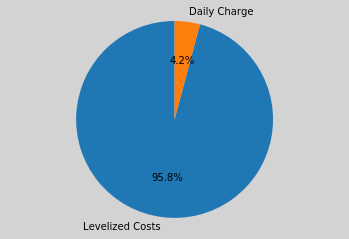

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[198.1529427920512, 162.76090123190977, 233.40647290824538, 38.441804962294654, 34.40560169825403, 41.387751384037486, 0.39402881758925223, 0.8372784613584869, 0.7811628630547165, 3201.09, 308.898, 171.063, 137.835, 0.0, {'Levelized Costs': 3068.0349999999994, 'Energy Charge': 0.013000000000602085, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60160041053, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200.99682441873975, 115.8470123890682, 109.31485428048529, 19.0102413719691, 34.0728821956078, 27.14510815921215, 0.746608322468989, 0.805620268948489, 0.7583082262703262)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 19.0
                                           and a gcr of 0.747


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5777013301849365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 116
                                           a tilt of 34.1
                                           and a gcr of 0.806


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3983521461486816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 27.1
                                           and a gcr of 0.758


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.411801338195801 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [311.624, 0.0, 0.0]


ERROR:ga_logger:Cost: 3228.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,228 per year


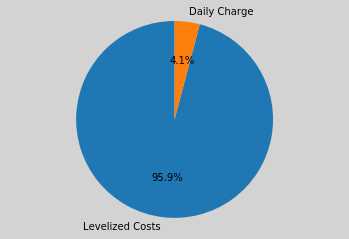

Total roof area of the  building: 599 m2
Total roof area used 417 m2
Percentage: 69.7%
succes
[[200.99682441873975, 115.8470123890682, 109.31485428048529, 19.0102413719691, 34.0728821956078, 27.14510815921215, 0.746608322468989, 0.805620268948489, 0.7583082262703262, 3228.16, 311.624, 311.624, 0.0, 0.0, {'Levelized Costs': 3095.1069999999995, 'Energy Charge': 0.011000000000422006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6012105553, 61845.7, 417.386]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.91432457371286, 213.40509923728487, 99.22255044399124, 20.355465454997095, 24.242679186119087, 10.582058539555039, 0.8308546656680715, 0.3423891365978991, 0.5299704827457062)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 20.4
                                           and a gcr of 0.831


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3788883686065674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 24.2
                                           and a gcr of 0.342


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3915932178497314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 99
                                           a tilt of 10.6
                                           and a gcr of 0.530


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3770976066589355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   8 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [193.732, 125.174, 0.0]


ERROR:ga_logger:Cost: 3300.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,300 per year


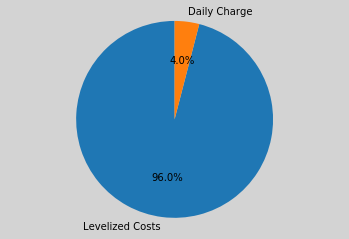

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.91432457371286, 213.40509923728487, 99.22255044399124, 20.355465454997095, 24.242679186119087, 10.582058539555039, 0.8308546656680715, 0.3423891365978991, 0.5299704827457062, 3300.49, 318.906, 193.732, 125.174, 0.0, {'Levelized Costs': 3167.439, 'Energy Charge': 0.008999999999900865, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60147543548, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.61689288068226, 145.22947103500167, 120.87258562985495, 26.9234866353839, 30.52399228604469, 19.634719082621956, 0.2581804126929048, 0.4296213926101681, 0.5723237473506106)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 26.9
                                           and a gcr of 0.258


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.403935432434082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 30.5
                                           and a gcr of 0.430


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.395216941833496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 121
                                           a tilt of 19.6
                                           and a gcr of 0.572


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3883306980133057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   8 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 74.2534, 243.768]


ERROR:ga_logger:Cost: 3291.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,292 per year


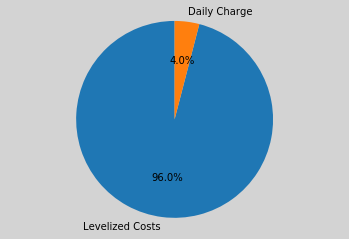

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.61689288068226, 145.22947103500167, 120.87258562985495, 26.9234866353839, 30.52399228604469, 19.634719082621956, 0.2581804126929048, 0.4296213926101681, 0.5723237473506106, 3291.71, 318.02139999999997, 0.0, 74.2534, 243.768, {'Levelized Costs': 3158.649, 'Energy Charge': 0.0190000000000623, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603053549974, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.21400602113525, 239.88963307845543, 132.10136265263932, 6.8564784878840905, 29.256825498491445, 24.780348443314587, 0.2433256293844295, 0.2097139416469965, 0.8125244915086542)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 6.9
                                           and a gcr of 0.243


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4195003509521484 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 29.3
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6383395195007324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 24.8
                                           and a gcr of 0.813


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.391632080078125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [65.4817, 0.0, 267.849]


ERROR:ga_logger:Cost: 3443.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,444 per year


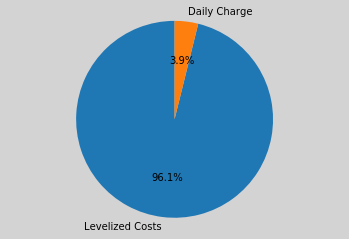

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[126.21400602113525, 239.88963307845543, 132.10136265263932, 6.8564784878840905, 29.256825498491445, 24.780348443314587, 0.2433256293844295, 0.2097139416469965, 0.8125244915086542, 3443.76, 333.3307, 65.4817, 0.0, 267.849, {'Levelized Costs': 3310.6910000000003, 'Energy Charge': 0.027000000000043656, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60296463894, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (94.2660255091179, 201.36711560636564, 177.03975419400092, 6.212456787030375, 51.54083160324588, 18.617027655383858, 0.8228594765599841, 0.33791711255950085, 0.2894536128204117)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 6.2
                                           and a gcr of 0.823


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8210957050323486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 201
                                           a tilt of 51.5
                                           and a gcr of 0.338


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3848624229431152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 18.6
                                           and a gcr of 0.289


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3989670276641846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [234.878, 0.0, 90.6917]


ERROR:ga_logger:Cost: 3366.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,367 per year


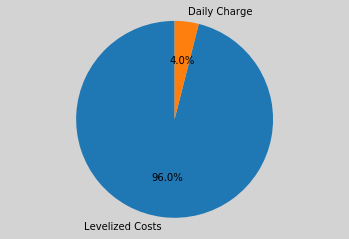

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[94.2660255091179, 201.36711560636564, 177.03975419400092, 6.212456787030375, 51.54083160324588, 18.617027655383858, 0.8228594765599841, 0.33791711255950085, 0.2894536128204117, 3366.68, 325.5697, 234.878, 0.0, 90.6917, {'Levelized Costs': 3233.629, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60050415777, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115.27415340522607, 236.44154899908565, 226.60349669338024, 29.369147931951986, 1.590447515867909, 35.023160846354294, 0.3197537212839174, 0.37812438780373514, 0.5946221850663156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 29.4
                                           and a gcr of 0.320


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.470698833465576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 236
                                           a tilt of 1.6
                                           and a gcr of 0.378


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2400147914886475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 227
                                           a tilt of 35.0
                                           and a gcr of 0.595


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.422999382019043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [34.0565, 0.0, 292.705]


ERROR:ga_logger:Cost: 3378.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,379 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[115.27415340522607, 236.44154899908565, 226.60349669338024, 29.369147931951986, 1.590447515867909, 35.023160846354294, 0.3197537212839174, 0.37812438780373514, 0.5946221850663156, 3378.51, 326.76149999999996, 34.0565, 0.0, 292.705, {'Levelized Costs': 3245.452, 'Energy Charge': 0.01600000000013324, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6028369791, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215.99378057900003, 153.6203607977401, 183.44239623285972, 28.987970812161613, 10.237936461525297, 36.73567301605641, 0.637437185007864, 0.23056005554677977, 0.5388482104031186)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 29.0
                                           and a gcr of 0.637


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4170756340026855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 10.2
                                           and a gcr of 0.231


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4267852306365967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 36.7
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4766743183135986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.283]


ERROR:ga_logger:Cost: 3085.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,086 per year


Total roof area of the  building: 599 m2
Total roof area used 552 m2
Percentage: 92.1%
succes
[[215.99378057900003, 153.6203607977401, 183.44239623285972, 28.987970812161613, 10.237936461525297, 36.73567301605641, 0.637437185007864, 0.23056005554677977, 0.5388482104031186, 3085.73, 297.283, 0.0, 0.0, 297.283, {'Levelized Costs': 2952.676, 'Energy Charge': 0.012000000000341515, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60177313326, 61845.7, 551.701]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (237.18662422225015, 183.10642710167963, 201.53202053646453, 39.7454818021559, 53.288136937506245, 1.332709207759954, 0.7469541722773525, 0.5777683173148742, 0.821750538458665)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 237
                                           a tilt of 39.7
                                           and a gcr of 0.747


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.418599843978882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 53.3
                                           and a gcr of 0.578


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4141674041748047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 1.3
                                           and a gcr of 0.822


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.988424301147461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   8 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 316.613, 0.0]


ERROR:ga_logger:Cost: 3277.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,278 per year


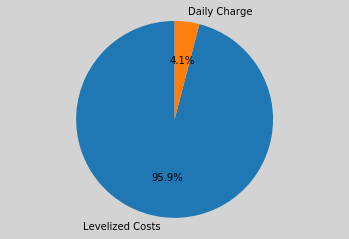

Total roof area of the  building: 599 m2
Total roof area used 548 m2
Percentage: 91.5%
succes
[[237.18662422225015, 183.10642710167963, 201.53202053646453, 39.7454818021559, 53.288136937506245, 1.332709207759954, 0.7469541722773525, 0.5777683173148742, 0.821750538458665, 3277.72, 316.613, 0.0, 316.613, 0.0, {'Levelized Costs': 3144.662, 'Energy Charge': 0.016000000000019554, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601562833115, 61845.7, 547.994]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (158.18880915476382, 103.35142147854782, 189.92263242968707, 34.49787048134834, 16.796024465598418, 52.60583681715656, 0.2170338511451061, 0.8069708974623808, 0.4585407186443886)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 34.5
                                           and a gcr of 0.217


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.49252986907959 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 16.8
                                           and a gcr of 0.807


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.390711784362793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 52.6
                                           and a gcr of 0.459


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.39021897315979 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 114.441, 209.529]


ERROR:ga_logger:Cost: 3350.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,351 per year


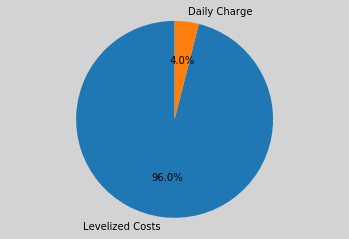

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[158.18880915476382, 103.35142147854782, 189.92263242968707, 34.49787048134834, 16.796024465598418, 52.60583681715656, 0.2170338511451061, 0.8069708974623808, 0.4585407186443886, 3350.78, 323.97, 0.0, 114.441, 209.529, {'Levelized Costs': 3217.726, 'Energy Charge': 0.012000000000000455, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60131693995, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (237.81658899767797, 171.6815225232435, 150.93907732470365, 11.492963907538938, 54.551308242173796, 32.482153450385425, 0.5393090927172555, 0.8657729304305251, 0.5395874273017733)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 238
                                           a tilt of 11.5
                                           and a gcr of 0.539


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4304721355438232 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 54.6
                                           and a gcr of 0.866


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3695273399353027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 32.5
                                           and a gcr of 0.540


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4332122802734375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


succes
[[237.81658899767797, 171.6815225232435, 150.93907732470365, 11.492963907538938, 54.551308242173796, 32.482153450385425, 0.5393090927172555, 0.8657729304305251, 0.5395874273017733, 90000000000, 0, 0.0, 0.0, 0.0, {'Levelized Costs': 0, 'Energy Charge': 10000000000, 'Demand Charge': 0, 'Daily Charge': 0}, 90000000000, 90000000000, 0]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.57184982611285, 160.2848023526961, 164.1111121111054, 10.980474358036155, 23.05914833693478, 34.756055505231906, 0.4139855292957749, 0.8228908178639709, 0.5769931277115576)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 11.0
                                           and a gcr of 0.414


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.464573621749878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 23.1
                                           and a gcr of 0.823


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3968698978424072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 34.8
                                           and a gcr of 0.577


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.388231039047241 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 302.723]


ERROR:ga_logger:Cost: 3139.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,140 per year


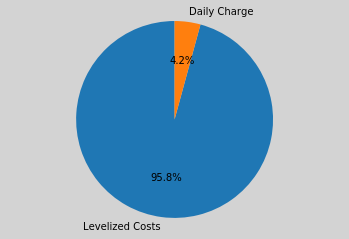

Total roof area of the  building: 599 m2
Total roof area used 525 m2
Percentage: 87.6%
succes
[[108.57184982611285, 160.2848023526961, 164.1111121111054, 10.980474358036155, 23.05914833693478, 34.756055505231906, 0.4139855292957749, 0.8228908178639709, 0.5769931277115576, 3139.76, 302.723, 0.0, 0.0, 302.723, {'Levelized Costs': 3006.704, 'Energy Charge': 0.014000000000180535, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600428299935, 61845.7, 524.655]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (223.50085047121394, 149.37064601518603, 183.74568044898433, 26.461771059357705, 26.296055577101434, 19.851214893022323, 0.33305787234830797, 0.8613273799020582, 0.2760026378046353)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 26.5
                                           and a gcr of 0.333


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.862997055053711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 26.3
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.38018798828125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 19.9
                                           and a gcr of 0.276


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.898411512374878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 226.422, 92.7053]


ERROR:ga_logger:Cost: 3302.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,303 per year


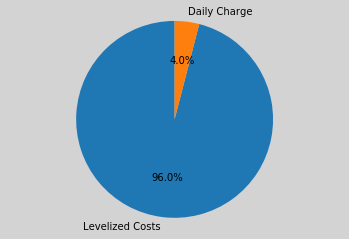

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[223.50085047121394, 149.37064601518603, 183.74568044898433, 26.461771059357705, 26.296055577101434, 19.851214893022323, 0.33305787234830797, 0.8613273799020582, 0.2760026378046353, 3302.7, 319.1273, 0.0, 226.422, 92.7053, {'Levelized Costs': 3169.6369999999997, 'Energy Charge': 0.02100000000007185, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601162976905, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (118.60389173895234, 173.23364401379655, 109.22351700281737, 7.190814711365068, 14.92544688144342, 31.66291950570712, 0.4362485011335654, 0.6667196892305041, 0.8653394710977791)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 7.2
                                           and a gcr of 0.436


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.515817880630493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 14.9
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.367889404296875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 31.7
                                           and a gcr of 0.865


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.377262830734253 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  95 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 307.649, 0.0]


ERROR:ga_logger:Cost: 3188.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,189 per year


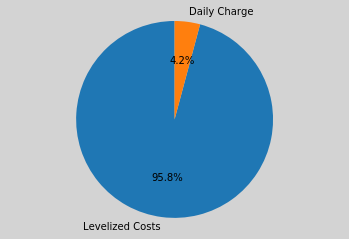

Total roof area of the  building: 599 m2
Total roof area used 461 m2
Percentage: 77.1%
succes
[[118.60389173895234, 173.23364401379655, 109.22351700281737, 7.190814711365068, 14.92544688144342, 31.66291950570712, 0.4362485011335654, 0.6667196892305041, 0.8653394710977791, 3188.69, 307.649, 0.0, 307.649, 0.0, {'Levelized Costs': 3055.6389999999997, 'Energy Charge': 0.009000000000241926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60031686701, 61845.7, 461.436]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.22180358255858, 212.88472671882943, 126.87840386147414, 40.86809214754412, 5.143803123166331, 1.3670166252266582, 0.5059874890642462, 0.5683986763104943, 0.272925675549682)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 40.9
                                           and a gcr of 0.506


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.801037549972534 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 5.1
                                           and a gcr of 0.568


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9038655757904053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 127
                                           a tilt of 1.4
                                           and a gcr of 0.273


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2736148834228516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  94 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [126.94, 197.737, 0.0]


ERROR:ga_logger:Cost: 3357.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,358 per year


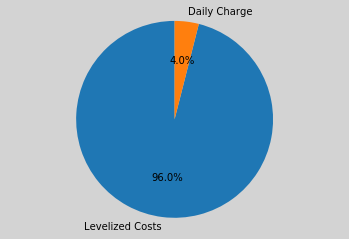

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[134.22180358255858, 212.88472671882943, 126.87840386147414, 40.86809214754412, 5.143803123166331, 1.3670166252266582, 0.5059874890642462, 0.5683986763104943, 0.272925675549682, 3357.82, 324.677, 126.94, 197.737, 0.0, {'Levelized Costs': 3224.764, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60058316401, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.45976526101677, 100.0744249790402, 262.9968729599848, 19.70336511933379, 5.4389484261127405, 32.341527607738996, 0.4322258328835674, 0.5667017881550744, 0.2724463455162217)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 19.7
                                           and a gcr of 0.432


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.55531644821167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 5.4
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.41794490814209 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 32.3
                                           and a gcr of 0.272


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4004056453704834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  93 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [30.5724, 299.235, 0.0]


ERROR:ga_logger:Cost: 3408.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,409 per year


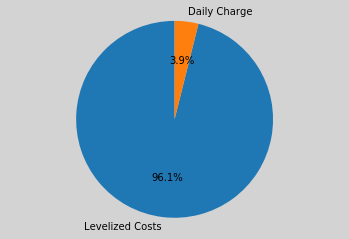

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[146.45976526101677, 100.0744249790402, 262.9968729599848, 19.70336511933379, 5.4389484261127405, 32.341527607738996, 0.4322258328835674, 0.5667017881550744, 0.2724463455162217, 3408.77, 329.80740000000003, 30.5724, 299.235, 0.0, {'Levelized Costs': 3275.718, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59966244111, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (92.95993599858699, 179.59513945960816, 237.38422634474696, 54.786509492762015, 3.191942294576246, 42.90077342613605, 0.7819845672754289, 0.7488404987172363, 0.4528308752493576)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 93
                                           a tilt of 54.8
                                           and a gcr of 0.782


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.847317934036255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 3.2
                                           and a gcr of 0.749


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.270663261413574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 42.9
                                           and a gcr of 0.453


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.394906520843506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 327.399, 0.0]


ERROR:ga_logger:Cost: 3384.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,385 per year


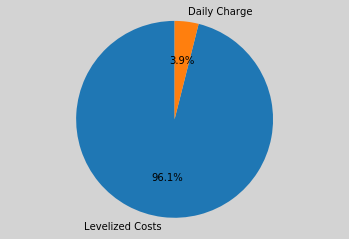

Total roof area of the  building: 599 m2
Total roof area used 437 m2
Percentage: 73.0%
succes
[[92.95993599858699, 179.59513945960816, 237.38422634474696, 54.786509492762015, 3.191942294576246, 42.90077342613605, 0.7819845672754289, 0.7488404987172363, 0.4528308752493576, 3384.85, 327.399, 0.0, 327.399, 0.0, {'Levelized Costs': 3251.801, 'Energy Charge': 0.006999999999948159, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60235720891, 61845.7, 437.208]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.61919885325563, 211.69728787215126, 227.73459007609367, 16.411330720722887, 41.07951470932936, 23.294908107399078, 0.23438238648306514, 0.43796601938079016, 0.44527046383953905)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 16.4
                                           and a gcr of 0.234


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9023590087890625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 212
                                           a tilt of 41.1
                                           and a gcr of 0.438


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.437714099884033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 228
                                           a tilt of 23.3
                                           and a gcr of 0.445


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.448573112487793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 262.237, 0.0]


ERROR:ga_logger:Cost: 3920.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0191 /kWh
Total Cost of the system: $ 3,921 per year


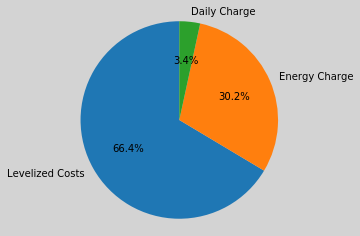

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[134.61919885325563, 211.69728787215126, 227.73459007609367, 16.411330720722887, 41.07951470932936, 23.294908107399078, 0.23438238648306514, 0.43796601938079016, 0.44527046383953905, 3920.99, 262.237, 0.0, 262.237, 0.0, {'Levelized Costs': 2604.5969999999998, 'Energy Charge': 1183.351, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 52401.57109233252, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (238.29518953159445, 238.16506121393255, 202.31686312707794, 23.984621762703668, 50.04338346457162, 39.060128112826476, 0.7800070903373788, 0.30928733219397636, 0.5249614428177583)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 238
                                           a tilt of 24.0
                                           and a gcr of 0.780


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8233261108398438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 50.0
                                           and a gcr of 0.309


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.444471836090088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 39.1
                                           and a gcr of 0.525


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4035258293151855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.908]


ERROR:ga_logger:Cost: 3171.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,171 per year


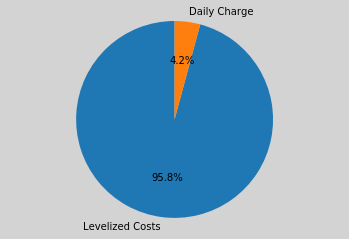

Total roof area of the  building: 599 m2
Total roof area used 583 m2
Percentage: 97.3%
succes
[[238.29518953159445, 238.16506121393255, 202.31686312707794, 23.984621762703668, 50.04338346457162, 39.060128112826476, 0.7800070903373788, 0.30928733219397636, 0.5249614428177583, 3171.4, 305.908, 0.0, 0.0, 305.908, {'Levelized Costs': 3038.3480000000004, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603051617254, 61845.7, 582.725]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (161.20043715598885, 233.24567745902394, 103.26147139633895, 48.45122544440581, 35.9142567041886, 42.327496207432894, 0.8032560592161784, 0.41006499224317955, 0.23014619807324802)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 48.5
                                           and a gcr of 0.803


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7832794189453125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 233
                                           a tilt of 35.9
                                           and a gcr of 0.410


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.441972494125366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 103
                                           a tilt of 42.3
                                           and a gcr of 0.230


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.63377046585083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [175.405, 155.986, 0.0]


ERROR:ga_logger:Cost: 3424.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,424 per year


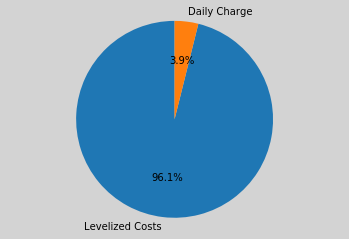

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[161.20043715598885, 233.24567745902394, 103.26147139633895, 48.45122544440581, 35.9142567041886, 42.327496207432894, 0.8032560592161784, 0.41006499224317955, 0.23014619807324802, 3424.5, 331.39099999999996, 175.405, 155.986, 0.0, {'Levelized Costs': 3291.44, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60148664877, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (111.18987844427384, 209.64414886589688, 184.93863254636966, 10.435089449240836, 23.20979337788858, 54.15566815989123, 0.20932166324793583, 0.5387445326902133, 0.42537742722157224)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 111
                                           a tilt of 10.4
                                           and a gcr of 0.209


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8197078704833984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 23.2
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6254332065582275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 54.2
                                           and a gcr of 0.425


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6416983604431152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 299 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 149s


ERROR:ga_logger:panel relevance: [0.0, 305.845, 0.0]


ERROR:ga_logger:Cost: 3170.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,171 per year


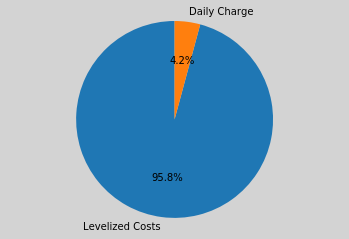

Total roof area of the  building: 599 m2
Total roof area used 568 m2
Percentage: 94.8%
succes
[[111.18987844427384, 209.64414886589688, 184.93863254636966, 10.435089449240836, 23.20979337788858, 54.15566815989123, 0.20932166324793583, 0.5387445326902133, 0.42537742722157224, 3170.77, 305.845, 0.0, 305.845, 0.0, {'Levelized Costs': 3037.705, 'Energy Charge': 0.02300000000025193, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600380343145, 61845.7, 567.7]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (197.12788399039167, 144.51180263101918, 123.88234577714621, 53.0767764060186, 28.94356626960243, 48.96265751318126, 0.7678649494357883, 0.6959853607556313, 0.7523660101727265)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 53.1
                                           and a gcr of 0.768


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8988614082336426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 28.9
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2972185611724854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 49.0
                                           and a gcr of 0.752


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3517048358917236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 334 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [0.0, 318.117, 0.0]


ERROR:ga_logger:Cost: 3292.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,293 per year


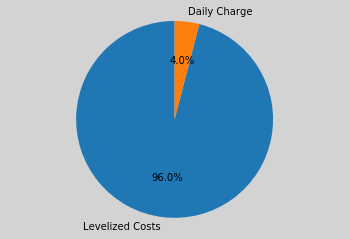

Total roof area of the  building: 599 m2
Total roof area used 457 m2
Percentage: 76.3%
succes
[[197.12788399039167, 144.51180263101918, 123.88234577714621, 53.0767764060186, 28.94356626960243, 48.96265751318126, 0.7678649494357883, 0.6959853607556313, 0.7523660101727265, 3292.65, 318.117, 0.0, 318.117, 0.0, {'Levelized Costs': 3159.585, 'Energy Charge': 0.023000000000138243, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60346931994, 61845.7, 457.074]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (181.55686916959706, 202.33719041837284, 192.53084086690836, 50.88771800477663, 54.77739330503272, 43.03793922178539, 0.30066446813822817, 0.87762859658678, 0.2798259583249658)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 50.9
                                           and a gcr of 0.301


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.587984085083008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 202
                                           a tilt of 54.8
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2867770195007324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 43.0
                                           and a gcr of 0.280


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4490468502044678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 333 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 139s


ERROR:ga_logger:panel relevance: [0.0, 255.599, 86.0531]


ERROR:ga_logger:Cost: 3526.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,526 per year


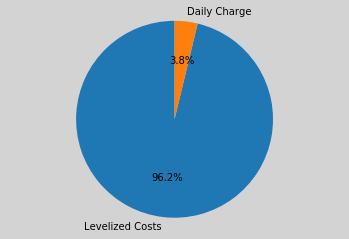

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[181.55686916959706, 202.33719041837284, 192.53084086690836, 50.88771800477663, 54.77739330503272, 43.03793922178539, 0.30066446813822817, 0.87762859658678, 0.2798259583249658, 3526.41, 341.6521, 0.0, 255.599, 86.0531, {'Levelized Costs': 3393.3519999999994, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59966699884, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (226.29035278263385, 181.0006953655988, 124.22711942964904, 50.57193223851012, 36.880400178651804, 40.49812046529957, 0.6519762703525518, 0.2211079606207899, 0.3287646568803002)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 50.6
                                           and a gcr of 0.652


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.716198682785034 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 36.9
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3535103797912598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 40.5
                                           and a gcr of 0.329


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.417888641357422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 331 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 143s


ERROR:ga_logger:panel relevance: [335.844, 18.4946, 0.0]


ERROR:ga_logger:Cost: 3652.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,652 per year


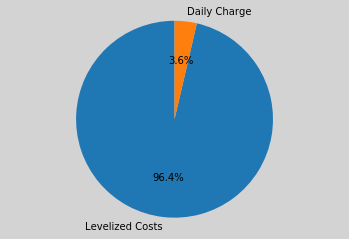

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[226.29035278263385, 181.0006953655988, 124.22711942964904, 50.57193223851012, 36.880400178651804, 40.49812046529957, 0.6519762703525518, 0.2211079606207899, 0.3287646568803002, 3652.42, 354.3386, 335.844, 18.4946, 0.0, {'Levelized Costs': 3519.363, 'Energy Charge': 0.015000000000270575, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600561186955, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (102.85186129449352, 111.59705238685545, 230.92319200195595, 41.53820171830269, 2.7403475135170328, 19.57862723419923, 0.46647445096731455, 0.37765382646635887, 0.2944464340618684)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 41.5
                                           and a gcr of 0.466


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7154440879821777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 2.7
                                           and a gcr of 0.378


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2108747959136963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 19.6
                                           and a gcr of 0.294


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3711652755737305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 370 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 138s


ERROR:ga_logger:panel relevance: [279.307, 0.0, 0.0]


ERROR:ga_logger:Cost: 4769.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0301 /kWh
Total Cost of the system: $ 4,769 per year


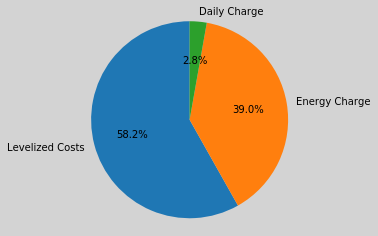

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[102.85186129449352, 111.59705238685545, 230.92319200195595, 41.53820171830269, 2.7403475135170328, 19.57862723419923, 0.46647445096731455, 0.37765382646635887, 0.2944464340618684, 4769.24, 279.307, 279.307, 0.0, 0.0, {'Levelized Costs': 2774.132, 'Energy Charge': 1862.066, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 46984.86139600002, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (224.74081273117767, 237.0244307374238, 130.83675786597766, 39.22092224693216, 11.688123755600676, 37.7813547845029, 0.7998796026622448, 0.46567912764302266, 0.2458151594388622)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 39.2
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6880528926849365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 11.7
                                           and a gcr of 0.466


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345503807067871 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 131
                                           a tilt of 37.8
                                           and a gcr of 0.246


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6823348999023438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 335 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 145s


ERROR:ga_logger:panel relevance: [134.627, 200.453, 0.0]


ERROR:ga_logger:Cost: 3461.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,461 per year


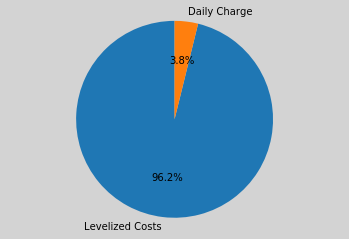

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[224.74081273117767, 237.0244307374238, 130.83675786597766, 39.22092224693216, 11.688123755600676, 37.7813547845029, 0.7998796026622448, 0.46567912764302266, 0.2458151594388622, 3461.14, 335.08000000000004, 134.627, 200.453, 0.0, {'Levelized Costs': 3328.0899999999997, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601046560674, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.77624229785292, 217.22647413818777, 155.1252272502272, 14.76338650698378, 50.06888076025338, 37.1980179842229, 0.22730678774131283, 0.8254716212815636, 0.36638993881915116)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 14.8
                                           and a gcr of 0.227


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.739853858947754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 50.1
                                           and a gcr of 0.825


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345086097717285 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 37.2
                                           and a gcr of 0.366


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.326559543609619 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 327 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 139s


ERROR:ga_logger:panel relevance: [0.0, 212.086, 125.245]


ERROR:ga_logger:Cost: 3483.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,484 per year


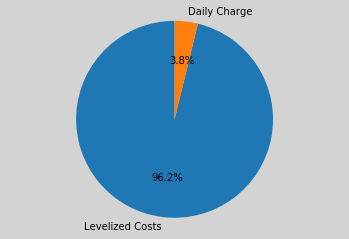

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[239.77624229785292, 217.22647413818777, 155.1252272502272, 14.76338650698378, 50.06888076025338, 37.1980179842229, 0.22730678774131283, 0.8254716212815636, 0.36638993881915116, 3483.5, 337.331, 0.0, 212.086, 125.245, {'Levelized Costs': 3350.4449999999997, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601179069105, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175.27543225960173, 139.97344721034528, 167.67982626875272, 30.40236808828643, 35.11355958475402, 11.686855696019961, 0.5366155578002623, 0.2609234044522622, 0.26283704071726655)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 30.4
                                           and a gcr of 0.537


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6120173931121826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 35.1
                                           and a gcr of 0.261


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.46356463432312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 11.7
                                           and a gcr of 0.263


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3762145042419434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 369 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 122s


ERROR:ga_logger:panel relevance: [296.861, 0.0, 0.0]


ERROR:ga_logger:Cost: 3081.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,082 per year


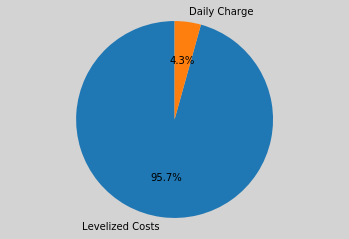

Total roof area of the  building: 599 m2
Total roof area used 553 m2
Percentage: 92.4%
succes
[[175.27543225960173, 139.97344721034528, 167.67982626875272, 30.40236808828643, 35.11355958475402, 11.686855696019961, 0.5366155578002623, 0.2609234044522622, 0.26283704071726655, 3081.54, 296.861, 296.861, 0.0, 0.0, {'Levelized Costs': 2948.489, 'Energy Charge': 0.009000000000071395, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60161150007, 61845.7, 553.21]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (138.34413480258098, 192.64262946742934, 159.94591663737242, 23.773774764946833, 24.636963780353557, 13.520516988151474, 0.42671629979219594, 0.6703438848281964, 0.5117038296060064)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 23.8
                                           and a gcr of 0.427


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6349945068359375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 193
                                           a tilt of 24.6
                                           and a gcr of 0.670


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.485654592514038 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 13.5
                                           and a gcr of 0.512


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3997483253479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 368 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 126s


ERROR:ga_logger:panel relevance: [0.0, 303.812, 0.0]


ERROR:ga_logger:Cost: 3150.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,151 per year


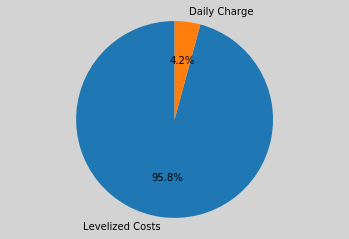

Total roof area of the  building: 599 m2
Total roof area used 453 m2
Percentage: 75.7%
succes
[[138.34413480258098, 192.64262946742934, 159.94591663737242, 23.773774764946833, 24.636963780353557, 13.520516988151474, 0.42671629979219594, 0.6703438848281964, 0.5117038296060064, 3150.58, 303.812, 0.0, 303.812, 0.0, {'Levelized Costs': 3017.5179999999996, 'Energy Charge': 0.02000000000032287, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60265512144, 61845.7, 453.218]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (234.80518471764873, 113.29283904208582, 247.60622880674197, 5.015022795773529, 7.076270006686722, 6.113939955257837, 0.706994270649093, 0.855650353417581, 0.8923409495260046)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 5.0
                                           and a gcr of 0.707


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.360783815383911 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 113
                                           a tilt of 7.1
                                           and a gcr of 0.856


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1858644485473633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 6.1
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1210098266601562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 343 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 142s


ERROR:ga_logger:panel relevance: [329.712, 0.0, 0.0]


ERROR:ga_logger:Cost: 3407.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,408 per year


Total roof area of the  building: 599 m2
Total roof area used 466 m2
Percentage: 77.9%
succes
[[234.80518471764873, 113.29283904208582, 247.60622880674197, 5.015022795773529, 7.076270006686722, 6.113939955257837, 0.706994270649093, 0.855650353417581, 0.8923409495260046, 3407.83, 329.712, 329.712, 0.0, 0.0, {'Levelized Costs': 3274.764, 'Energy Charge': 0.023999999999773536, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60141034957, 61845.7, 466.358]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (240.80053452424198, 176.7490156513312, 111.95760161790662, 29.400832833844635, 44.303825641872514, 22.93158459559928, 0.6330818350418603, 0.28938154954108597, 0.6395461851961024)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 29.4
                                           and a gcr of 0.633


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.583362579345703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 44.3
                                           and a gcr of 0.289


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.38210391998291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 22.9
                                           and a gcr of 0.640


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3536369800567627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 316 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 142s


ERROR:ga_logger:panel relevance: [0.0, 43.026, 287.846]


ERROR:ga_logger:Cost: 3419.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,419 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[240.80053452424198, 176.7490156513312, 111.95760161790662, 29.400832833844635, 44.303825641872514, 22.93158459559928, 0.6330818350418603, 0.28938154954108597, 0.6395461851961024, 3419.35, 330.872, 0.0, 43.026, 287.846, {'Levelized Costs': 3286.2979999999993, 'Energy Charge': 0.010000000000445652, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60044326984, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (167.1385180959228, 213.75362113823698, 247.7164133956746, 1.2431365756969979, 17.20230741050879, 27.495487929976694, 0.8108149794769346, 0.2260822740944763, 0.3896955333638782)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 1.2
                                           and a gcr of 0.811


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2603952884674072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 214
                                           a tilt of 17.2
                                           and a gcr of 0.226


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3766517639160156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 27.5
                                           and a gcr of 0.390


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.436589479446411 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 357 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 142s


ERROR:ga_logger:panel relevance: [266.742, 60.9929, 0.0]


ERROR:ga_logger:Cost: 3388.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,388 per year


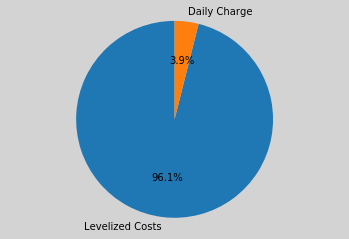

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[167.1385180959228, 213.75362113823698, 247.7164133956746, 1.2431365756969979, 17.20230741050879, 27.495487929976694, 0.8108149794769346, 0.2260822740944763, 0.3896955333638782, 3388.18, 327.73490000000004, 266.742, 60.9929, 0.0, {'Levelized Costs': 3255.115, 'Energy Charge': 0.02300000000025193, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600868783695, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.92364159753924, 198.1555286602783, 181.19551778165737, 45.235275668066485, 32.67081354981249, 54.43934082739652, 0.22246479184795115, 0.20773498333959606, 0.3181486630943092)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 45.2
                                           and a gcr of 0.222


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6567442417144775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 32.7
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5999958515167236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 54.4
                                           and a gcr of 0.318


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.359729766845703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 321 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 236s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 190.495]


ERROR:ga_logger:Cost: 4962.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0475 /kWh
Total Cost of the system: $ 4,962 per year


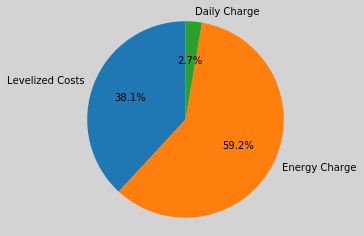

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[199.92364159753924, 198.1555286602783, 181.19551778165737, 45.235275668066485, 32.67081354981249, 54.43934082739652, 0.22246479184795115, 0.20773498333959606, 0.3181486630943092, 4962.04, 190.495, 0.0, 0.0, 190.495, {'Levelized Costs': 1892.034, 'Energy Charge': 2936.964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 38406.26817781924, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (194.59330938122957, 251.61231180844104, 260.92838435468616, 24.037913968266945, 55.57515991461432, 46.379424674605765, 0.7850659306575622, 0.37288096109254987, 0.7391705435938614)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 24.0
                                           and a gcr of 0.785


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.039377927780151 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 252
                                           a tilt of 55.6
                                           and a gcr of 0.373


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7538158893585205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 46.4
                                           and a gcr of 0.739


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.405076026916504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 334 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 141s


ERROR:ga_logger:panel relevance: [311.76, 0.0, 0.0]


ERROR:ga_logger:Cost: 3229.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,230 per year


Total roof area of the  building: 599 m2
Total roof area used 397 m2
Percentage: 66.3%
succes
[[194.59330938122957, 251.61231180844104, 260.92838435468616, 24.037913968266945, 55.57515991461432, 46.379424674605765, 0.7850659306575622, 0.37288096109254987, 0.7391705435938614, 3229.52, 311.76, 311.76, 0.0, 0.0, {'Levelized Costs': 3096.468, 'Energy Charge': 0.010000000000047748, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60076853949, 61845.7, 397.113]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (231.74767459272067, 170.71037091228038, 184.89662643677372, 9.987541073978523, 42.949635132236224, 46.885698453011116, 0.49017704267242473, 0.21865873262013058, 0.4120460532567305)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 232
                                           a tilt of 10.0
                                           and a gcr of 0.490


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.436541795730591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 42.9
                                           and a gcr of 0.219


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0583388805389404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 46.9
                                           and a gcr of 0.412


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4251325130462646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 346 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 162s


ERROR:ga_logger:panel relevance: [293.499, 0.0, 0.0]


ERROR:ga_logger:Cost: 3762.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0115 /kWh
Total Cost of the system: $ 3,762 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[231.74767459272067, 170.71037091228038, 184.89662643677372, 9.987541073978523, 42.949635132236224, 46.885698453011116, 0.49017704267242473, 0.21865873262013058, 0.4120460532567305, 3762.37, 293.499, 293.499, 0.0, 0.0, {'Levelized Costs': 2915.0989999999997, 'Energy Charge': 714.229, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56145.52327866024, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195.0652689505404, 194.7338643185991, 182.77131895225776, 50.908550341056625, 29.167312457644577, 46.0669524585071, 0.7600979357230999, 0.42854017357990437, 0.8474861941772562)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 50.9
                                           and a gcr of 0.760


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8707287311553955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 29.2
                                           and a gcr of 0.429


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.379439353942871 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 46.1
                                           and a gcr of 0.847


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3701939582824707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 359 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 152s


ERROR:ga_logger:panel relevance: [0.0, 207.478, 97.132]


ERROR:ga_logger:Cost: 3158.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,158 per year


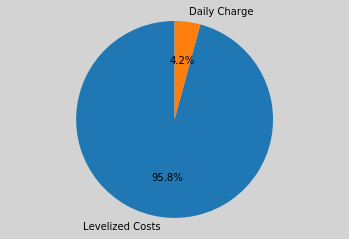

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[195.0652689505404, 194.7338643185991, 182.77131895225776, 50.908550341056625, 29.167312457644577, 46.0669524585071, 0.7600979357230999, 0.42854017357990437, 0.8474861941772562, 3158.5, 304.61, 0.0, 207.478, 97.132, {'Levelized Costs': 3025.4469999999997, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60069790631, 61845.7, 598.762]]


ERROR:optimizer_logger:50


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215.99378057900003, 172.50738219563934, 195.092237380244, 41.03848102909244, 44.89848386696896, 41.746560886634384, 0.637437185007864, 0.7893132844249466, 0.5433594863277955)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 41.0
                                           and a gcr of 0.637


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6336309909820557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 44.9
                                           and a gcr of 0.789


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3331708908081055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 41.7
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.312821865081787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 373 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 122s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.104]


ERROR:ga_logger:Cost: 3163.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,163 per year


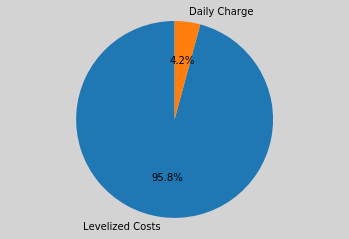

Total roof area of the  building: 599 m2
Total roof area used 562 m2
Percentage: 93.8%
succes
[[215.99378057900003, 172.50738219563934, 195.092237380244, 41.03848102909244, 44.89848386696896, 41.746560886634384, 0.637437185007864, 0.7893132844249466, 0.5433594863277955, 3163.41, 305.104, 0.0, 0.0, 305.104, {'Levelized Costs': 3030.359, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602381167286, 61845.7, 561.515]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.74297263935982, 155.96332424756142, 155.55001347020945, 31.723949266881643, 5.581875862733293, 32.48419445824091, 0.5983636823595935, 0.21459615538122614, 0.29409610295940525)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 31.7
                                           and a gcr of 0.598


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.70336651802063 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 156
                                           a tilt of 5.6
                                           and a gcr of 0.215


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3059799671173096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 156
                                           a tilt of 32.5
                                           and a gcr of 0.294


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4007110595703125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 368 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 132s


ERROR:ga_logger:panel relevance: [322.217, 0.0, 17.7235]


ERROR:ga_logger:Cost: 3509.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,509 per year


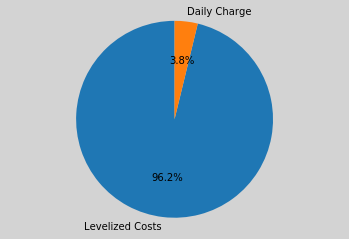

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[114.74297263935982, 155.96332424756142, 155.55001347020945, 31.723949266881643, 5.581875862733293, 32.48419445824091, 0.5983636823595935, 0.21459615538122614, 0.29409610295940525, 3509.42, 339.9405, 322.217, 0.0, 17.7235, {'Levelized Costs': 3376.365, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60261613001, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (198.60755490109108, 162.56487695306524, 245.1377393070748, 38.252480389226264, 38.116444379863275, 41.45235663728011, 0.4148455019063039, 0.8343851614901523, 0.7811857687844895)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 38.3
                                           and a gcr of 0.415


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7482690811157227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 38.1
                                           and a gcr of 0.834


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.32058048248291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 41.5
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.360506057739258 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 376 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 190s


ERROR:ga_logger:panel relevance: [188.391, 120.685, 0.0]


ERROR:ga_logger:Cost: 3202.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,203 per year


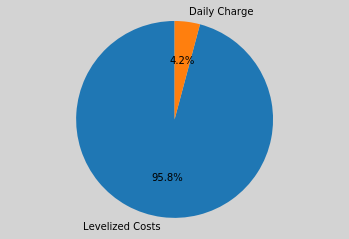

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[198.60755490109108, 162.56487695306524, 245.1377393070748, 38.252480389226264, 38.116444379863275, 41.45235663728011, 0.4148455019063039, 0.8343851614901523, 0.7811857687844895, 3202.86, 309.076, 188.391, 120.685, 0.0, {'Levelized Costs': 3069.806, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60029889801, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.12465099818685, 160.4339157883397, 160.6886823948136, 4.7947940396421185, 23.191681281040285, 31.525491347228623, 0.389946277502182, 0.819945075955241, 0.5769702080957214)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 108
                                           a tilt of 4.8
                                           and a gcr of 0.390


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.362701892852783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 23.2
                                           and a gcr of 0.820


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4203999042510986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 31.5
                                           and a gcr of 0.577


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3922924995422363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 328 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 140s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 302.617]


ERROR:ga_logger:Cost: 3138.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,139 per year


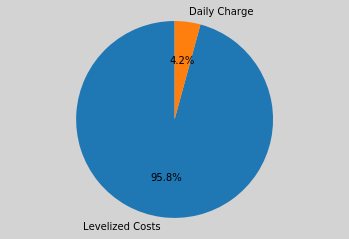

Total roof area of the  building: 599 m2
Total roof area used 524 m2
Percentage: 87.6%
succes
[[108.12465099818685, 160.4339157883397, 160.6886823948136, 4.7947940396421185, 23.191681281040285, 31.525491347228623, 0.389946277502182, 0.819945075955241, 0.5769702080957214, 3138.71, 302.617, 0.0, 0.0, 302.617, {'Levelized Costs': 3005.658, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601705100045, 61845.7, 524.494]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (187.92204687974632, 250.05243119255775, 258.56503590348393, 41.70340283412119, 54.671788411040126, 48.32786925800231, 0.8880186556882019, 0.450842052796318, 0.7649274780256865)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 188
                                           a tilt of 41.7
                                           and a gcr of 0.888


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8120243549346924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 54.7
                                           and a gcr of 0.451


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.410780429840088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 48.3
                                           and a gcr of 0.765


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3743271827697754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 334 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 142s


ERROR:ga_logger:panel relevance: [327.78, 0.0, 0.0]


ERROR:ga_logger:Cost: 3388.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,389 per year


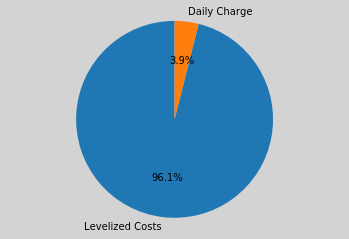

Total roof area of the  building: 599 m2
Total roof area used 369 m2
Percentage: 61.6%
succes
[[187.92204687974632, 250.05243119255775, 258.56503590348393, 41.70340283412119, 54.671788411040126, 48.32786925800231, 0.8880186556882019, 0.450842052796318, 0.7649274780256865, 3388.63, 327.78, 327.78, 0.0, 0.0, {'Levelized Costs': 3255.5750000000003, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60101719465, 61845.7, 369.114]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (167.11470696713118, 92.06757297567891, 161.66171752237972, 24.03762178782705, 36.716361641068566, 20.48851755664178, 0.7805714750147864, 0.4283897932769403, 0.5708668452371891)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 24.0
                                           and a gcr of 0.781


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8344740867614746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 36.7
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.429198980331421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 20.5
                                           and a gcr of 0.571


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4082255363464355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 329 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 302.569]


ERROR:ga_logger:Cost: 3138.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,138 per year


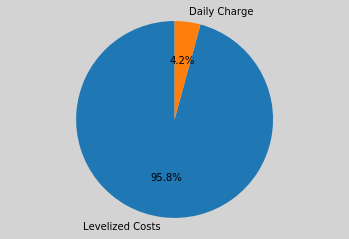

Total roof area of the  building: 599 m2
Total roof area used 530 m2
Percentage: 88.5%
succes
[[167.11470696713118, 92.06757297567891, 161.66171752237972, 24.03762178782705, 36.716361641068566, 20.48851755664178, 0.7805714750147864, 0.4283897932769403, 0.5708668452371891, 3138.23, 302.569, 0.0, 0.0, 302.569, {'Levelized Costs': 3005.172, 'Energy Charge': 0.015999999999849024, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602904100146, 61845.7, 530.017]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.7201357253368, 219.38572879870125, 177.03975419400092, 40.57442849693832, 41.880952296849316, 18.757767214760204, 0.8016641448963157, 0.5830406341746098, 0.27147386803440404)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 40.6
                                           and a gcr of 0.802


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7493362426757812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 41.9
                                           and a gcr of 0.583


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5583012104034424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 18.8
                                           and a gcr of 0.271


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4235806465148926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 344 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [0.0, 303.913, 21.0409]


ERROR:ga_logger:Cost: 3360.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,361 per year


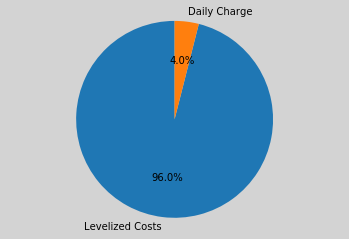

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[133.7201357253368, 219.38572879870125, 177.03975419400092, 40.57442849693832, 41.880952296849316, 18.757767214760204, 0.8016641448963157, 0.5830406341746098, 0.27147386803440404, 3360.57, 324.95390000000003, 0.0, 303.913, 21.0409, {'Levelized Costs': 3227.509, 'Energy Charge': 0.019000000000289674, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60140955908, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (94.79550001486392, 206.28210035080355, 126.87840386147414, 6.652185815850942, 5.143803123166331, 1.455965294131011, 0.5452578584834727, 0.306550591510394, 0.2412608051800033)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.7
                                           and a gcr of 0.545


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.760390043258667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 5.1
                                           and a gcr of 0.307


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2463483810424805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 127
                                           a tilt of 1.5
                                           and a gcr of 0.241


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1777307987213135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 342 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 132s


ERROR:ga_logger:panel relevance: [326.48, 0.0, 0.0]


ERROR:ga_logger:Cost: 3549.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0028 /kWh
Total Cost of the system: $ 3,550 per year


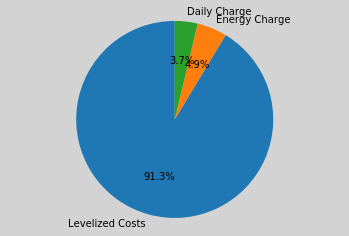

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[94.79550001486392, 206.28210035080355, 126.87840386147414, 6.652185815850942, 5.143803123166331, 1.455965294131011, 0.5452578584834727, 0.306550591510394, 0.2412608051800033, 3549.78, 326.48, 326.48, 0.0, 0.0, {'Levelized Costs': 3242.6560000000004, 'Energy Charge': 174.082, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60456.39519348985, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (228.86099629850094, 231.39221972239466, 249.68965524774575, 21.493543877153467, 53.09740831819415, 54.9656162689099, 0.894405425774477, 0.45905310664800403, 0.509365483700561)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 229
                                           a tilt of 21.5
                                           and a gcr of 0.894


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.625047206878662 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 231
                                           a tilt of 53.1
                                           and a gcr of 0.459


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7367851734161377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 55.0
                                           and a gcr of 0.509


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3569016456604004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 337 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 181s


ERROR:ga_logger:panel relevance: [344.303, 0.0, 0.0]


ERROR:ga_logger:Cost: 3552.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,553 per year


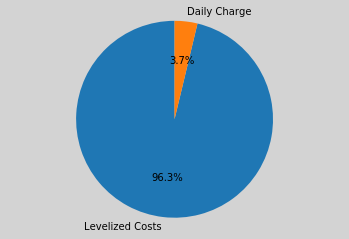

Total roof area of the  building: 599 m2
Total roof area used 385 m2
Percentage: 64.3%
succes
[[228.86099629850094, 231.39221972239466, 249.68965524774575, 21.493543877153467, 53.09740831819415, 54.9656162689099, 0.894405425774477, 0.45905310664800403, 0.509365483700561, 3552.74, 344.303, 344.303, 0.0, 0.0, {'Levelized Costs': 3419.6859999999997, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602822132634, 61845.7, 384.952]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (109.64461608916983, 215.87706011788708, 201.8427809379853, 2.102696368278287, 44.79451661118643, 37.25278266735757, 0.7797031786551731, 0.3153125784632997, 0.492621217284216)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 2.1
                                           and a gcr of 0.780


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.749809741973877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 44.8
                                           and a gcr of 0.315


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4552860260009766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 37.3
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4970972537994385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 373 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 226s


ERROR:ga_logger:panel relevance: [28.2862, 0.0, 277.091]


ERROR:ga_logger:Cost: 3166.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,166 per year


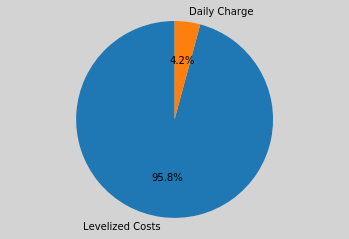

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[109.64461608916983, 215.87706011788708, 201.8427809379853, 2.102696368278287, 44.79451661118643, 37.25278266735757, 0.7797031786551731, 0.3153125784632997, 0.492621217284216, 3166.13, 305.3772, 28.2862, 0.0, 277.091, {'Levelized Costs': 3033.078, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60253567383, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (167.1385180959228, 212.70973826616958, 247.7164133956746, 12.305255592894017, 41.2287117026614, 30.10202771690698, 0.7190159536836039, 0.2369092050024737, 0.4336175171317943)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 12.3
                                           and a gcr of 0.719


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9228806495666504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 41.2
                                           and a gcr of 0.237


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4255056381225586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 30.1
                                           and a gcr of 0.434


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4413609504699707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 344 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 180s


ERROR:ga_logger:panel relevance: [251.616, 58.9468, 0.0]


ERROR:ga_logger:Cost: 3217.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,218 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[167.1385180959228, 212.70973826616958, 247.7164133956746, 12.305255592894017, 41.2287117026614, 30.10202771690698, 0.7190159536836039, 0.2369092050024737, 0.4336175171317943, 3217.63, 310.56280000000004, 251.616, 58.9468, 0.0, {'Levelized Costs': 3084.5660000000003, 'Energy Charge': 0.021999999999934516, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60276939206, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (121.06261171085934, 205.09336347153962, 233.40998625004354, 1.5711648606871158, 15.620393033698557, 28.959451449314592, 0.34934675041211444, 0.26953403237592866, 0.2954123068784185)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 1.6
                                           and a gcr of 0.349


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8160955905914307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 15.6
                                           and a gcr of 0.270


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5858957767486572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 29.0
                                           and a gcr of 0.295


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4360477924346924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 333 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [209.175, 0.0, 0.0]


ERROR:ga_logger:Cost: 5096.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 47,436 kWh
At a cost of $ 0.0608 /kWh
Total Cost of the system: $ 5,097 per year


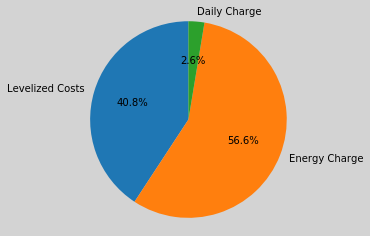

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[121.06261171085934, 205.09336347153962, 233.40998625004354, 1.5711648606871158, 15.620393033698557, 28.959451449314592, 0.34934675041211444, 0.26953403237592866, 0.2954123068784185, 5096.88, 209.175, 209.175, 0.0, 0.0, {'Levelized Costs': 2077.5706, 'Energy Charge': 2886.2674, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 38810.85093398722, 47436.4, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170.0388354327983, 213.40509923728487, 249.64651174381274, 17.76606363584024, 24.242679186119087, 38.84843782000264, 0.8272301206993323, 0.5671373585112995, 0.5084321657171526)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 17.8
                                           and a gcr of 0.827


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8735122680664062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 24.2
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3620729446411133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 38.8
                                           and a gcr of 0.508


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.362079381942749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 348 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [0.0, 308.645, 0.0]


ERROR:ga_logger:Cost: 3198.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,199 per year


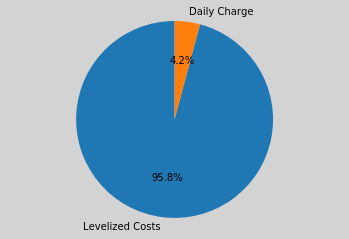

Total roof area of the  building: 599 m2
Total roof area used 544 m2
Percentage: 90.9%
succes
[[170.0388354327983, 213.40509923728487, 249.64651174381274, 17.76606363584024, 24.242679186119087, 38.84843782000264, 0.8272301206993323, 0.5671373585112995, 0.5084321657171526, 3198.58, 308.645, 0.0, 308.645, 0.0, {'Levelized Costs': 3065.52, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60315479496, 61845.7, 544.216]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.82352386726615, 187.72247971545445, 97.34432847343724, 37.28516225518481, 1.4378322465945528, 12.314352696678723, 0.4777122906979701, 0.40036739668123156, 0.5523728615257473)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 37.3
                                           and a gcr of 0.478


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9437901973724365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 1.4
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1714489459991455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 97
                                           a tilt of 12.3
                                           and a gcr of 0.552


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3624765872955322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 346 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 140s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 330.74]


ERROR:ga_logger:Cost: 3517.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0016 /kWh
Total Cost of the system: $ 3,518 per year


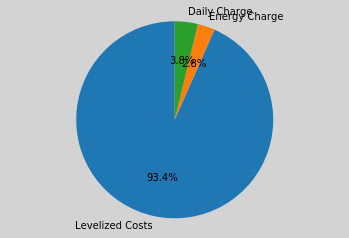

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[135.82352386726615, 187.72247971545445, 97.34432847343724, 37.28516225518481, 1.4378322465945528, 12.314352696678723, 0.4777122906979701, 0.40036739668123156, 0.5523728615257473, 3517.83, 330.74, 0.0, 0.0, 330.74, {'Levelized Costs': 3284.9779999999996, 'Energy Charge': 99.8100000000004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61049.12417153014, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.3647159232272, 193.74805991325556, 155.78314933602675, 52.16744821500718, 28.94356626960243, 44.79867342891802, 0.7243273186574237, 0.7249557722338292, 0.7523660101727265)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 52.2
                                           and a gcr of 0.724


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.005123853683472 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 28.9
                                           and a gcr of 0.725


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4233059883117676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 156
                                           a tilt of 44.8
                                           and a gcr of 0.752


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.456854820251465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 299 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 127s


ERROR:ga_logger:panel relevance: [0.0, 308.086, 0.0]


ERROR:ga_logger:Cost: 3193.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,193 per year


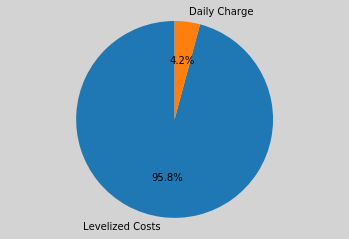

Total roof area of the  building: 599 m2
Total roof area used 425 m2
Percentage: 71.0%
succes
[[186.3647159232272, 193.74805991325556, 155.78314933602675, 52.16744821500718, 28.94356626960243, 44.79867342891802, 0.7243273186574237, 0.7249557722338292, 0.7523660101727265, 3193.02, 308.086, 0.0, 308.086, 0.0, {'Levelized Costs': 3059.975, 'Energy Charge': 0.0030000000002132765, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60149986577, 61845.7, 424.971]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (138.34413480258098, 144.85070071020684, 189.61674925573848, 24.64545279628593, 27.53238440240629, 13.520516988151474, 0.42671629979219594, 0.5384712500810621, 0.5117038296060064)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 24.6
                                           and a gcr of 0.427


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.270639657974243 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 27.5
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.778475284576416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 13.5
                                           and a gcr of 0.512


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1972339153289795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 105 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


succes
[[138.34413480258098, 144.85070071020684, 189.61674925573848, 24.64545279628593, 27.53238440240629, 13.520516988151474, 0.42671629979219594, 0.5384712500810621, 0.5117038296060064, 90000000000, 0, 0.0, 0.0, 0.0, {'Levelized Costs': 0, 'Energy Charge': 10000000000, 'Demand Charge': 0, 'Daily Charge': 0}, 90000000000, 90000000000, 0]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (178.9807435993761, 236.59282592117816, 260.075141065392, 18.887467879006525, 17.598640538823098, 33.11757892702865, 0.8108149794769346, 0.4577693186163981, 0.3941928839588439)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 18.9
                                           and a gcr of 0.811


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2311959266662598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 17.6
                                           and a gcr of 0.458


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.832026720046997 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 33.1
                                           and a gcr of 0.394


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.589235782623291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [311.697, 0.0, 0.0]


ERROR:ga_logger:Cost: 3228.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,229 per year


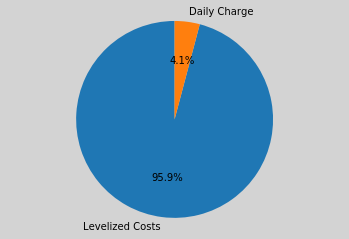

Total roof area of the  building: 599 m2
Total roof area used 384 m2
Percentage: 64.2%
succes
[[178.9807435993761, 236.59282592117816, 260.075141065392, 18.887467879006525, 17.598640538823098, 33.11757892702865, 0.8108149794769346, 0.4577693186163981, 0.3941928839588439, 3228.9, 311.697, 311.697, 0.0, 0.0, {'Levelized Costs': 3095.844, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60121505354, 61845.7, 384.425]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (157.92065232324467, 213.7761886047133, 236.3479407010195, 1.926747227898412, 11.788852772252298, 31.781992130714496, 0.7328304742870947, 0.3068078275017991, 0.3894642642730206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 1.9
                                           and a gcr of 0.733


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.215470314025879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 214
                                           a tilt of 11.8
                                           and a gcr of 0.307


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.926453590393066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 236
                                           a tilt of 31.8
                                           and a gcr of 0.389


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9249932765960693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [245.835, 80.783, 0.0]


ERROR:ga_logger:Cost: 3377.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,377 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[157.92065232324467, 213.7761886047133, 236.3479407010195, 1.926747227898412, 11.788852772252298, 31.781992130714496, 0.7328304742870947, 0.3068078275017991, 0.3894642642730206, 3377.1, 326.618, 245.835, 80.783, 0.0, {'Levelized Costs': 3244.04, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60322750831, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (201.17157794864562, 252.132602181179, 179.6422218266702, 22.95853318996864, 46.21090137828191, 17.599587870778674, 0.841802204353171, 0.4054767386141025, 0.7141170845353525)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 23.0
                                           and a gcr of 0.842


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3673956394195557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 252
                                           a tilt of 46.2
                                           and a gcr of 0.405


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.831716299057007 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 17.6
                                           and a gcr of 0.714


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.792605400085449 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 113 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.885]


ERROR:ga_logger:Cost: 3181.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,181 per year


Total roof area of the  building: 599 m2
Total roof area used 430 m2
Percentage: 71.8%
succes
[[201.17157794864562, 252.132602181179, 179.6422218266702, 22.95853318996864, 46.21090137828191, 17.599587870778674, 0.841802204353171, 0.4054767386141025, 0.7141170845353525, 3181.1, 306.885, 0.0, 0.0, 306.885, {'Levelized Costs': 3048.037, 'Energy Charge': 0.02100000000024238, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60052595514, 61845.7, 429.741]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (96.10963652348909, 197.72742991537453, 258.4017173706832, 15.347082157413706, 51.21594171396769, 41.62791694970225, 0.7434061938834526, 0.3498986657855649, 0.3111578381087823)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 15.3
                                           and a gcr of 0.743


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1419742107391357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 51.2
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.878798246383667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 41.6
                                           and a gcr of 0.311


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6166515350341797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 107 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [236.812, 98.0456, 0.0]


ERROR:ga_logger:Cost: 3458.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,459 per year


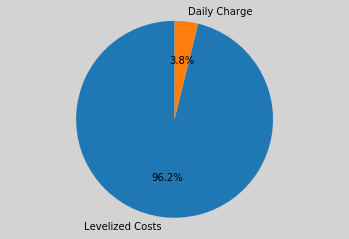

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[96.10963652348909, 197.72742991537453, 258.4017173706832, 15.347082157413706, 51.21594171396769, 41.62791694970225, 0.7434061938834526, 0.3498986657855649, 0.3111578381087823, 3458.93, 334.8576, 236.812, 98.0456, 0.0, {'Levelized Costs': 3325.874, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60343313994, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.32632655312463, 145.98926149215902, 244.52791521706277, 32.220509477479595, 32.44002627149184, 44.09191218101994, 0.7164529260294297, 0.6724126447612566, 0.6362058315714543)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 32.2
                                           and a gcr of 0.716


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.04088020324707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 146
                                           a tilt of 32.4
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1204168796539307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 44.1
                                           and a gcr of 0.636


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1235899925231934 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 199 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [305.818, 0.0, 0.0]


ERROR:ga_logger:Cost: 3170.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,170 per year


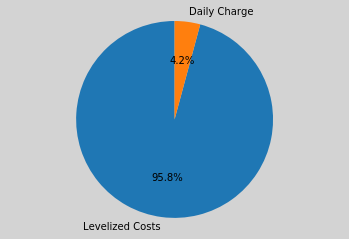

Total roof area of the  building: 599 m2
Total roof area used 427 m2
Percentage: 71.3%
succes
[[186.32632655312463, 145.98926149215902, 244.52791521706277, 32.220509477479595, 32.44002627149184, 44.09191218101994, 0.7164529260294297, 0.6724126447612566, 0.6362058315714543, 3170.5, 305.818, 305.818, 0.0, 0.0, {'Levelized Costs': 3037.4379999999996, 'Energy Charge': 0.02000000000032287, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59921806716, 61845.7, 426.849]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.0728187700838, 138.82910622224975, 154.1135583027865, 28.843645658701664, 4.886188669571561, 14.429833105017762, 0.5385058390680307, 0.23444670856511488, 0.2209382756088464)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 28.8
                                           and a gcr of 0.539


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.387139081954956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 139
                                           a tilt of 4.9
                                           and a gcr of 0.234


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.824636459350586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 14.4
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.893505334854126 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [299.709, 0.0, 0.0]


ERROR:ga_logger:Cost: 3109.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,110 per year


Total roof area of the  building: 599 m2
Total roof area used 557 m2
Percentage: 93.0%
succes
[[162.0728187700838, 138.82910622224975, 154.1135583027865, 28.843645658701664, 4.886188669571561, 14.429833105017762, 0.5385058390680307, 0.23444670856511488, 0.2209382756088464, 3109.82, 299.709, 299.709, 0.0, 0.0, {'Levelized Costs': 2976.766, 'Energy Charge': 0.012000000000341515, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60134870009, 61845.7, 556.556]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (194.59330938122957, 263.25105297964365, 260.92838435468616, 24.037913968266945, 55.57515991461432, 46.379424674605765, 0.8994745100486178, 0.838258168965702, 0.7810470571700772)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 24.0
                                           and a gcr of 0.899


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0889346599578857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 55.6
                                           and a gcr of 0.838


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.021334171295166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 46.4
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5150272846221924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [322.466, 0.0, 0.0]


ERROR:ga_logger:Cost: 3335.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,336 per year


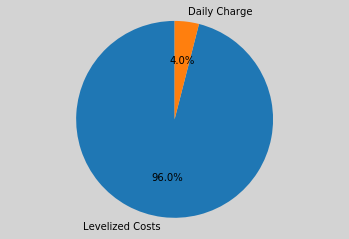

Total roof area of the  building: 599 m2
Total roof area used 359 m2
Percentage: 59.9%
succes
[[194.59330938122957, 263.25105297964365, 260.92838435468616, 24.037913968266945, 55.57515991461432, 46.379424674605765, 0.8994745100486178, 0.838258168965702, 0.7810470571700772, 3335.85, 322.466, 322.466, 0.0, 0.0, {'Levelized Costs': 3202.792, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60003358654, 61845.7, 358.505]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.71151378562298, 254.1764522695626, 160.69456142563362, 13.169969969342354, 37.367080228572775, 19.608417391021938, 0.6951653192961084, 0.3708778260083148, 0.7437357973412698)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 13.2
                                           and a gcr of 0.695


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7298684120178223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 254
                                           a tilt of 37.4
                                           and a gcr of 0.371


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0911953449249268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 19.6
                                           and a gcr of 0.744


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0523629188537598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 218 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.676]


ERROR:ga_logger:Cost: 3218.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ -0.0000 /kWh
Total Cost of the system: $ 3,219 per year


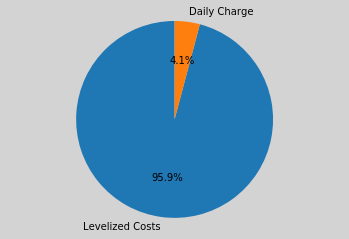

Total roof area of the  building: 599 m2
Total roof area used 418 m2
Percentage: 69.8%
succes
[[114.71151378562298, 254.1764522695626, 160.69456142563362, 13.169969969342354, 37.367080228572775, 19.608417391021938, 0.6951653192961084, 0.3708778260083148, 0.7437357973412698, 3218.75, 310.676, 0.0, 0.0, 310.676, {'Levelized Costs': 3085.712, 'Energy Charge': -0.003999999999791726, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600006949, 61845.7, 417.724]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (224.01738688336124, 208.0985855979512, 248.27805262639222, 25.377790069033882, 17.379853746004592, 21.248536618046987, 0.7732536707321283, 0.8515513862522879, 0.5273269865163651)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 25.4
                                           and a gcr of 0.773


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.575969696044922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 17.4
                                           and a gcr of 0.852


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7968673706054688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 21.2
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7769007682800293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 322.466, 0.0]


ERROR:ga_logger:Cost: 3335.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,336 per year


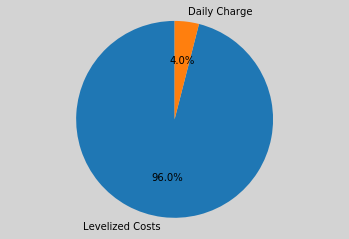

Total roof area of the  building: 599 m2
Total roof area used 379 m2
Percentage: 63.2%
succes
[[224.01738688336124, 208.0985855979512, 248.27805262639222, 25.377790069033882, 17.379853746004592, 21.248536618046987, 0.7732536707321283, 0.8515513862522879, 0.5273269865163651, 3335.85, 322.466, 0.0, 322.466, 0.0, {'Levelized Costs': 3202.795, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60050204892, 61845.7, 378.68]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.40644858177734, 148.99272230948827, 185.8801437889163, 2.7002636562032585, 26.181244202775638, 20.654488854448502, 0.33305787234830797, 0.2013578956808495, 0.2760026378046353)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 2.7
                                           and a gcr of 0.333


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3370203971862793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 26.2
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.843838691711426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 20.7
                                           and a gcr of 0.276


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.860360622406006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [199.422, 0.0, 0.0]


ERROR:ga_logger:Cost: 5158.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0492 /kWh
Total Cost of the system: $ 5,159 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[162.40644858177734, 148.99272230948827, 185.8801437889163, 2.7002636562032585, 26.181244202775638, 20.654488854448502, 0.33305787234830797, 0.2013578956808495, 0.2760026378046353, 5158.71, 199.422, 199.422, 0.0, 0.0, {'Levelized Costs': 1980.6995999999995, 'Energy Charge': 3044.9684000000007, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 37544.29872422008, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.77624229785292, 250.33235965042522, 244.89227723351996, 24.85316924609763, 55.427359346991054, 46.124590813881426, 0.7590550724294256, 0.7809467177891953, 0.728664023131393)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 24.9
                                           and a gcr of 0.759


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3886101245880127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 55.4
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.688161611557007 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 46.1
                                           and a gcr of 0.729


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6801905632019043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 153s


ERROR:ga_logger:panel relevance: [344.15, 0.0, 0.0]


ERROR:ga_logger:Cost: 3551.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,551 per year


Total roof area of the  building: 599 m2
Total roof area used 453 m2
Percentage: 75.7%
succes
[[239.77624229785292, 250.33235965042522, 244.89227723351996, 24.85316924609763, 55.427359346991054, 46.124590813881426, 0.7590550724294256, 0.7809467177891953, 0.728664023131393, 3551.22, 344.15, 344.15, 0.0, 0.0, {'Levelized Costs': 3418.1499999999996, 'Energy Charge': 0.02800000000036107, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60055447409, 61845.7, 453.393]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (207.01232561189008, 211.14234946306343, 133.09121731402976, 13.948131230415955, 48.80607634640424, 37.6133056680627, 0.2799577268140809, 0.37288096109254987, 0.3851449856268734)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 207
                                           a tilt of 13.9
                                           and a gcr of 0.280


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2704825401306152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 48.8
                                           and a gcr of 0.373


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1965155601501465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 133
                                           a tilt of 37.6
                                           and a gcr of 0.385


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.132803440093994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 230.61]


ERROR:ga_logger:Cost: 4476.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0332 /kWh
Total Cost of the system: $ 4,476 per year


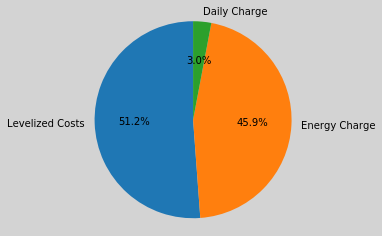

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[207.01232561189008, 211.14234946306343, 133.09121731402976, 13.948131230415955, 48.80607634640424, 37.6133056680627, 0.2799577268140809, 0.37288096109254987, 0.3851449856268734, 4476.19, 230.61, 0.0, 0.0, 230.61, {'Levelized Costs': 2290.4649999999997, 'Energy Charge': 2052.683, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 45463.54908002999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175.27543225960173, 140.77788378312937, 264.3225458563497, 36.925459253722764, 35.11355958475402, 40.53948575011504, 0.6276175883729631, 0.6108276730115035, 0.6082305862500541)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 36.9
                                           and a gcr of 0.628


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5551745891571045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 141
                                           a tilt of 35.1
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7952980995178223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 40.5
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8121039867401123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [303.676, 0.0, 0.0]


ERROR:ga_logger:Cost: 3149.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,149 per year


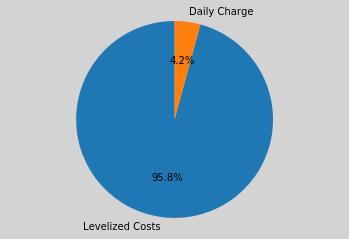

Total roof area of the  building: 599 m2
Total roof area used 484 m2
Percentage: 80.8%
succes
[[175.27543225960173, 140.77788378312937, 264.3225458563497, 36.925459253722764, 35.11355958475402, 40.53948575011504, 0.6276175883729631, 0.6108276730115035, 0.6082305862500541, 3149.23, 303.676, 303.676, 0.0, 0.0, {'Levelized Costs': 3016.169, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60205868998, 61845.7, 483.856]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.0728187700838, 109.06518865656594, 169.66135898362174, 30.41958073945151, 1.218764442862055, 11.671397219973889, 0.5254806525522185, 0.2838048696490616, 0.39644201039943)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 30.4
                                           and a gcr of 0.525


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5341596603393555 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 109
                                           a tilt of 1.2
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4917409420013428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 11.7
                                           and a gcr of 0.396


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0205371379852295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [299.38, 0.0, 0.0]


ERROR:ga_logger:Cost: 3106.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,107 per year


Total roof area of the  building: 599 m2
Total roof area used 570 m2
Percentage: 95.2%
succes
[[162.0728187700838, 109.06518865656594, 169.66135898362174, 30.41958073945151, 1.218764442862055, 11.671397219973889, 0.5254806525522185, 0.2838048696490616, 0.39644201039943, 3106.56, 299.38, 299.38, 0.0, 0.0, {'Levelized Costs': 2973.504, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603906200246, 61845.7, 569.727]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.15324913351068, 240.07898136543196, 259.3723697933449, 22.366271184401604, 20.10925672225698, 36.896185605998056, 0.7425115278559834, 0.62090009379422, 0.8325903968265598)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 22.4
                                           and a gcr of 0.743


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.552431344985962 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 20.1
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.781689405441284 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 36.9
                                           and a gcr of 0.833


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.754580497741699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [306.13, 0.0, 0.0]


ERROR:ga_logger:Cost: 3173.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,174 per year


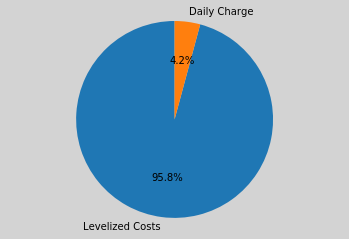

Total roof area of the  building: 599 m2
Total roof area used 412 m2
Percentage: 68.9%
succes
[[186.15324913351068, 240.07898136543196, 259.3723697933449, 22.366271184401604, 20.10925672225698, 36.896185605998056, 0.7425115278559834, 0.62090009379422, 0.8325903968265598, 3173.6, 306.13, 306.13, 0.0, 0.0, {'Levelized Costs': 3040.545, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59966033528, 61845.7, 412.29]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (118.54200152390786, 149.1179599110012, 98.94369556056284, 6.825353144266009, 13.757674500711614, 38.892061270967496, 0.48373335124083283, 0.4924887598333852, 0.40560811086246895)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 6.8
                                           and a gcr of 0.484


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.462942600250244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 13.8
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.771491765975952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 99
                                           a tilt of 38.9
                                           and a gcr of 0.406


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7789061069488525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 294.883, 0.0]


ERROR:ga_logger:Cost: 3432.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0060 /kWh
Total Cost of the system: $ 3,433 per year


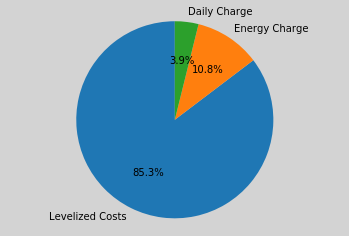

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[118.54200152390786, 149.1179599110012, 98.94369556056284, 6.825353144266009, 13.757674500711614, 38.892061270967496, 0.48373335124083283, 0.4924887598333852, 0.40560811086246895, 3432.59, 294.883, 0.0, 294.883, 0.0, {'Levelized Costs': 2928.851, 'Energy Charge': 370.69700000000023, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58887.1839006311, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (211.13576982775353, 111.98036489878318, 165.029150854418, 37.944003629632924, 34.38096893151509, 26.85294359037529, 0.828374831056097, 0.7895427639799, 0.8027579251523547)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 211
                                           a tilt of 37.9
                                           and a gcr of 0.828


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.557295799255371 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 34.4
                                           and a gcr of 0.790


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.524738311767578 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 26.9
                                           and a gcr of 0.803


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.514331579208374 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.694]


ERROR:ga_logger:Cost: 3258.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,259 per year


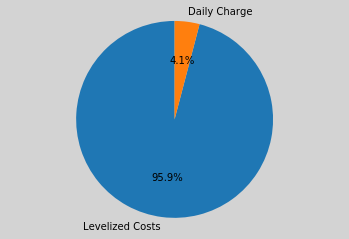

Total roof area of the  building: 599 m2
Total roof area used 392 m2
Percentage: 65.5%
succes
[[211.13576982775353, 111.98036489878318, 165.029150854418, 37.944003629632924, 34.38096893151509, 26.85294359037529, 0.828374831056097, 0.7895427639799, 0.8027579251523547, 3258.66, 314.694, 0.0, 0.0, 314.694, {'Levelized Costs': 3125.6109999999994, 'Energy Charge': 0.007000000000289219, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60149826949, 61845.7, 392.016]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.69688964855146, 98.91937770738093, 109.31485428048529, 18.10163569398633, 31.261537969914478, 16.433965991129753, 0.7435361472195123, 0.47557504438755316, 0.5874458720774097)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 18.1
                                           and a gcr of 0.744


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2269585132598877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 31.3
                                           and a gcr of 0.476


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.751328945159912 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 16.4
                                           and a gcr of 0.587


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7715210914611816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [315.972, 0.0, 0.0]


ERROR:ga_logger:Cost: 3271.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,271 per year


Total roof area of the  building: 599 m2
Total roof area used 425 m2
Percentage: 71.0%
succes
[[146.69688964855146, 98.91937770738093, 109.31485428048529, 18.10163569398633, 31.261537969914478, 16.433965991129753, 0.7435361472195123, 0.47557504438755316, 0.5874458720774097, 3271.35, 315.972, 315.972, 0.0, 0.0, {'Levelized Costs': 3138.2989999999995, 'Energy Charge': 0.009000000000298769, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60199555998, 61845.7, 424.959]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (161.20043715598885, 233.24567745902394, 203.07148974696224, 46.89158588399745, 35.9142567041886, 55.24441699324038, 0.8032560592161784, 0.5729873535928856, 0.43018721525023634)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 46.9
                                           and a gcr of 0.803


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.374748945236206 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 233
                                           a tilt of 35.9
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4811489582061768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 55.2
                                           and a gcr of 0.430


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7303123474121094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 175 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 129s


ERROR:ga_logger:panel relevance: [152.034, 0.0, 176.157]


ERROR:ga_logger:Cost: 3392.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,393 per year


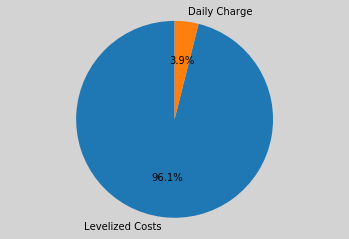

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[161.20043715598885, 233.24567745902394, 203.07148974696224, 46.89158588399745, 35.9142567041886, 55.24441699324038, 0.8032560592161784, 0.5729873535928856, 0.43018721525023634, 3392.72, 328.19100000000003, 152.034, 0.0, 176.157, {'Levelized Costs': 3259.663, 'Energy Charge': 0.014999999999929514, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60347034502, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.54068109473877, 219.31637828610232, 99.56091427546872, 10.435089449240836, 23.20979337788858, 39.51214901148434, 0.20906655860900508, 0.4732633279828442, 0.21755187177630006)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 10.4
                                           and a gcr of 0.209


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5509629249572754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 23.2
                                           and a gcr of 0.473


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7849509716033936 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 39.5
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8731207847595215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 283.372, 0.0]


ERROR:ga_logger:Cost: 3600.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0106 /kWh
Total Cost of the system: $ 3,601 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[147.54068109473877, 219.31637828610232, 99.56091427546872, 10.435089449240836, 23.20979337788858, 39.51214901148434, 0.20906655860900508, 0.4732633279828442, 0.21755187177630006, 3600.9, 283.372, 0.0, 283.372, 0.0, {'Levelized Costs': 2814.5049999999997, 'Energy Charge': 653.3530000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56631.436321346555, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.47892836378716, 223.6291475370107, 186.8650100310154, 34.49787048134834, 37.05863521100113, 46.75817907611857, 0.8967944796141414, 0.7374341414297364, 0.809187506626175)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 34.5
                                           and a gcr of 0.897


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3504011631011963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 224
                                           a tilt of 37.1
                                           and a gcr of 0.737


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6631288528442383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 46.8
                                           and a gcr of 0.809


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.601473569869995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 181s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.538]


ERROR:ga_logger:Cost: 3366.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,366 per year


Total roof area of the  building: 599 m2
Total roof area used 402 m2
Percentage: 67.2%
succes
[[162.47892836378716, 223.6291475370107, 186.8650100310154, 34.49787048134834, 37.05863521100113, 46.75817907611857, 0.8967944796141414, 0.7374341414297364, 0.809187506626175, 3366.37, 325.538, 0.0, 0.0, 325.538, {'Levelized Costs': 3233.3179999999998, 'Energy Charge': 0.010000000000388809, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60270200072, 61845.7, 402.302]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.75710856814791, 112.00565406927149, 164.5185083823479, 17.453089691643612, 17.104469569415713, 22.267091790990758, 0.20913531307750527, 0.7921810080142424, 0.4958413660966202)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 17.5
                                           and a gcr of 0.209


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4652485847473145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 17.1
                                           and a gcr of 0.792


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.593555450439453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 22.3
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5684239864349365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 8.665, 291.467]


ERROR:ga_logger:Cost: 3114.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,114 per year


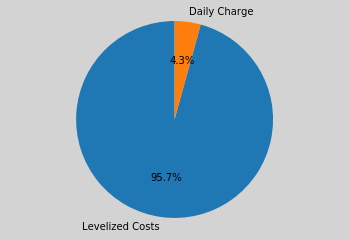

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.75710856814791, 112.00565406927149, 164.5185083823479, 17.453089691643612, 17.104469569415713, 22.267091790990758, 0.20913531307750527, 0.7921810080142424, 0.4958413660966202, 3114.03, 300.132, 0.0, 8.665, 291.467, {'Levelized Costs': 2980.963, 'Energy Charge': 0.025000000000204636, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601505178056, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (226.42393527180118, 238.16506121393255, 202.31686312707794, 23.984621762703668, 50.04338346457162, 39.060128112826476, 0.7800070903373788, 0.7776925307187639, 0.5771251442322952)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 24.0
                                           and a gcr of 0.780


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2590279579162598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 50.0
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7214882373809814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 39.1
                                           and a gcr of 0.577


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.502225160598755 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.054]


ERROR:ga_logger:Cost: 3202.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,203 per year


Total roof area of the  building: 599 m2
Total roof area used 536 m2
Percentage: 89.4%
succes
[[226.42393527180118, 238.16506121393255, 202.31686312707794, 23.984621762703668, 50.04338346457162, 39.060128112826476, 0.7800070903373788, 0.7776925307187639, 0.5771251442322952, 3202.64, 309.054, 0.0, 0.0, 309.054, {'Levelized Costs': 3069.5879999999997, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60059930256, 61845.7, 535.505]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (122.16878585544251, 155.8409057232612, 163.16445489574218, 10.980474358036155, 17.119135898256484, 24.744440474001387, 0.4139855292957749, 0.3542308834662582, 0.7270622989738544)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 122
                                           a tilt of 11.0
                                           and a gcr of 0.414


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5560128688812256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 156
                                           a tilt of 17.1
                                           and a gcr of 0.354


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7821435928344727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 163
                                           a tilt of 24.7
                                           and a gcr of 0.727


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7917866706848145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 122.475, 183.955]


ERROR:ga_logger:Cost: 3176.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,177 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[122.16878585544251, 155.8409057232612, 163.16445489574218, 10.980474358036155, 17.119135898256484, 24.744440474001387, 0.4139855292957749, 0.3542308834662582, 0.7270622989738544, 3176.59, 306.43, 0.0, 122.475, 183.955, {'Levelized Costs': 3043.539, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604037041325, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (232.69807818040465, 186.99197541518362, 201.53202053646453, 37.69241563547489, 53.354721862064196, 20.497610451018602, 0.7402043095824887, 0.8838962884132983, 0.821750538458665)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 233
                                           a tilt of 37.7
                                           and a gcr of 0.740


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4303159713745117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 53.4
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5483622550964355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 20.5
                                           and a gcr of 0.822


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8480796813964844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 118 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.266]


ERROR:ga_logger:Cost: 3284.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,284 per year


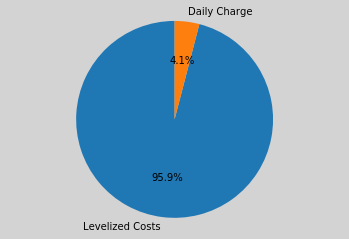

Total roof area of the  building: 599 m2
Total roof area used 386 m2
Percentage: 64.5%
succes
[[232.69807818040465, 186.99197541518362, 201.53202053646453, 37.69241563547489, 53.354721862064196, 20.497610451018602, 0.7402043095824887, 0.8838962884132983, 0.821750538458665, 3284.21, 317.266, 0.0, 0.0, 317.266, {'Levelized Costs': 3151.152, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60101651283, 61845.7, 386.086]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110.46835096894749, 231.48684240055593, 164.5185083823479, 11.669087016408794, 37.367080228572775, 1.4795570606913842, 0.8389431798741894, 0.5590808393416836, 0.8105823082853052)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 11.7
                                           and a gcr of 0.839


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.342595100402832 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 231
                                           a tilt of 37.4
                                           and a gcr of 0.559


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.61279559135437 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 1.5
                                           and a gcr of 0.811


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.2992961406707764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 185 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 331.99]


ERROR:ga_logger:Cost: 3430.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,430 per year


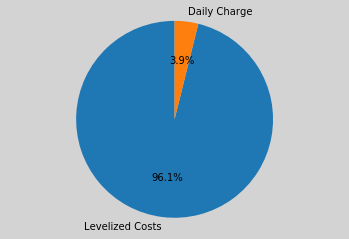

Total roof area of the  building: 599 m2
Total roof area used 410 m2
Percentage: 68.4%
succes
[[110.46835096894749, 231.48684240055593, 164.5185083823479, 11.669087016408794, 37.367080228572775, 1.4795570606913842, 0.8389431798741894, 0.5590808393416836, 0.8105823082853052, 3430.45, 331.99, 0.0, 0.0, 331.99, {'Levelized Costs': 3297.403, 'Energy Charge': 0.005000000000336513, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602440085415, 61845.7, 409.57]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (167.5985523414892, 233.25524815774423, 157.61226789627685, 48.45122544440581, 35.949960926327115, 41.92738860142214, 0.8267536349869361, 0.514263028150025, 0.6720275567825128)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 48.5
                                           and a gcr of 0.827


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6161184310913086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 233
                                           a tilt of 35.9
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.805203676223755 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 158
                                           a tilt of 41.9
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.770994186401367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.835]


ERROR:ga_logger:Cost: 3299.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,300 per year


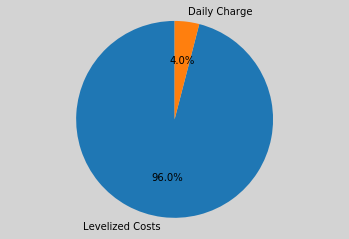

Total roof area of the  building: 599 m2
Total roof area used 474 m2
Percentage: 79.2%
succes
[[167.5985523414892, 233.25524815774423, 157.61226789627685, 48.45122544440581, 35.949960926327115, 41.92738860142214, 0.8267536349869361, 0.514263028150025, 0.6720275567825128, 3299.79, 318.835, 0.0, 0.0, 318.835, {'Levelized Costs': 3166.739, 'Energy Charge': 0.009000000000185082, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60221149984, 61845.7, 474.438]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.47585456350532, 195.33121906368515, 108.419228759172, 27.540819708408225, 28.63621057147619, 41.74054892494763, 0.8020094500761789, 0.28338963491758157, 0.23212514128533848)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 27.5
                                           and a gcr of 0.802


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.518770933151245 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 28.6
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.804645538330078 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 108
                                           a tilt of 41.7
                                           and a gcr of 0.232


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.606707811355591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [227.608, 89.2579, 0.0]


ERROR:ga_logger:Cost: 3280.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,280 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.47585456350532, 195.33121906368515, 108.419228759172, 27.540819708408225, 28.63621057147619, 41.74054892494763, 0.8020094500761789, 0.28338963491758157, 0.23212514128533848, 3280.23, 316.8659, 227.608, 89.2579, 0.0, {'Levelized Costs': 3147.1659999999997, 'Energy Charge': 0.022000000000389264, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60365869145, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (163.48909834529988, 233.78662703491307, 99.12148967482393, 18.983287265094813, 17.41904939741855, 29.403726281328552, 0.7654462851805689, 0.6667196892305041, 0.6944404740002703)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 163
                                           a tilt of 19.0
                                           and a gcr of 0.765


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.575199604034424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 234
                                           a tilt of 17.4
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7367265224456787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 99
                                           a tilt of 29.4
                                           and a gcr of 0.694


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6246330738067627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 190s


ERROR:ga_logger:panel relevance: [311.3, 0.0, 0.0]


ERROR:ga_logger:Cost: 3224.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,225 per year


Total roof area of the  building: 599 m2
Total roof area used 407 m2
Percentage: 67.9%
succes
[[163.48909834529988, 233.78662703491307, 99.12148967482393, 18.983287265094813, 17.41904939741855, 29.403726281328552, 0.7654462851805689, 0.6667196892305041, 0.6944404740002703, 3224.95, 311.3, 311.3, 0.0, 0.0, {'Levelized Costs': 3091.898, 'Energy Charge': 0.009999999999763531, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60053239837, 61845.7, 406.69]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.29337869600299, 162.4423880907246, 258.99820624756654, 6.442643682161479, 13.940748700639373, 36.673976834383176, 0.44581954034607996, 0.4566929191399584, 0.4659864278573579)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 6.4
                                           and a gcr of 0.446


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.622286796569824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 162
                                           a tilt of 13.9
                                           and a gcr of 0.457


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.794542074203491 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 36.7
                                           and a gcr of 0.466


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7958192825317383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 273.45, 0.0]


ERROR:ga_logger:Cost: 3684.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0135 /kWh
Total Cost of the system: $ 3,684 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[125.29337869600299, 162.4423880907246, 258.99820624756654, 6.442643682161479, 13.940748700639373, 36.673976834383176, 0.44581954034607996, 0.4566929191399584, 0.4659864278573579, 3684.18, 273.45, 0.0, 273.45, 0.0, {'Levelized Costs': 2715.9709999999995, 'Energy Charge': 835.1670000000004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55180.32333085979, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.01362482308065, 229.08000877343713, 263.06892307574645, 27.665095674623416, 43.246613114994304, 42.304493097112, 0.7706586349789728, 0.47612716167284513, 0.6441168027594654)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 27.7
                                           and a gcr of 0.771


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.648876667022705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 229
                                           a tilt of 43.2
                                           and a gcr of 0.476


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.768280267715454 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 42.3
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.680518627166748 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [143.117, 196.667, 0.0]


ERROR:ga_logger:Cost: 3507.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,508 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[241.01362482308065, 229.08000877343713, 263.06892307574645, 27.665095674623416, 43.246613114994304, 42.304493097112, 0.7706586349789728, 0.47612716167284513, 0.6441168027594654, 3507.85, 339.784, 143.117, 196.667, 0.0, {'Levelized Costs': 3374.7939999999994, 'Energy Charge': 0.014000000000407908, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598629499, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (171.32940510522914, 173.38756010520407, 111.95760161790662, 20.268206771002873, 18.400213861850602, 20.622469630504106, 0.6351448110695928, 0.20362785211665482, 0.45187134147037816)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 171
                                           a tilt of 20.3
                                           and a gcr of 0.635


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5935184955596924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 18.4
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5883631706237793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 20.6
                                           and a gcr of 0.452


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.140294313430786 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 265 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [265.772, 36.7178, 0.0]


ERROR:ga_logger:Cost: 3137.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,137 per year


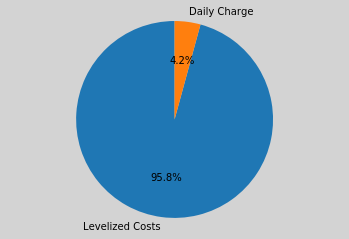

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[171.32940510522914, 173.38756010520407, 111.95760161790662, 20.268206771002873, 18.400213861850602, 20.622469630504106, 0.6351448110695928, 0.20362785211665482, 0.45187134147037816, 3137.45, 302.4898, 265.772, 36.7178, 0.0, {'Levelized Costs': 3004.3799999999997, 'Energy Charge': 0.02800000000002001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60213034207, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (194.59330938122957, 246.71671390454037, 260.92838435468616, 28.65508821000695, 55.18732636635883, 46.379424674605765, 0.8982559842454224, 0.883134395172372, 0.8102461826196207)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 28.7
                                           and a gcr of 0.898


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7654311656951904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 247
                                           a tilt of 55.2
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9042367935180664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 46.4
                                           and a gcr of 0.810


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8903541564941406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [323.948, 0.0, 0.0]


ERROR:ga_logger:Cost: 3350.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,351 per year


Total roof area of the  building: 599 m2
Total roof area used 361 m2
Percentage: 60.2%
succes
[[194.59330938122957, 246.71671390454037, 260.92838435468616, 28.65508821000695, 55.18732636635883, 46.379424674605765, 0.8982559842454224, 0.883134395172372, 0.8102461826196207, 3350.58, 323.948, 323.948, 0.0, 0.0, {'Levelized Costs': 3217.52, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60057686692, 61845.7, 360.641]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.75710856814791, 227.8106436076952, 171.11170049431624, 12.682241527657725, 42.51978352427373, 23.971964440534073, 0.7865806613299002, 0.3195964778933174, 0.790921966848347)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 12.7
                                           and a gcr of 0.787


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.665527820587158 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 228
                                           a tilt of 42.5
                                           and a gcr of 0.320


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7838351726531982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 24.0
                                           and a gcr of 0.791


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.856085777282715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 108 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.055]


ERROR:ga_logger:Cost: 3222.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,223 per year


Total roof area of the  building: 599 m2
Total roof area used 393 m2
Percentage: 65.7%
succes
[[124.75710856814791, 227.8106436076952, 171.11170049431624, 12.682241527657725, 42.51978352427373, 23.971964440534073, 0.7865806613299002, 0.3195964778933174, 0.790921966848347, 3222.52, 311.055, 0.0, 0.0, 311.055, {'Levelized Costs': 3089.465, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59972398715, 61845.7, 393.281]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 1 using opt-method ga-50 with 100 evalautions took: (min)


ERROR:Runs_logger:627.1517973661423


In [29]:
# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE")
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)